# Assignment 3: 3-Layer Neural Network Image Classification(Patchify Layer)

## Libraries and Imports

In [1]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

## Data

In [2]:
file_path = "./data/debug_info.npz"
load_data = np.load(file_path)

In [3]:
# download data
import tarfile
import urllib.request
import os
import shutil

url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
filename = "cifar-10-python.tar.gz"
DATA_PATH = "Datasets/"

if not os.path.exists(DATA_PATH):
    urllib.request.urlretrieve(url, filename)
    with tarfile.open(filename, "r:gz") as tar:
        tar.extractall()

    os.rename("cifar-10-batches-py", DATA_PATH)
    os.remove(filename)

/var/folders/73/y8z3_15n0c3fnwk5fkhj6ql40000gn/T/ipykernel_15242/3720980113.py:14: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


In [4]:
# store data for building model
data = {}
for key in load_data.files:
    data[key] = load_data[key]
    print(f"Load {key} - shape: {data[key].shape}")
load_data.close()

Load X - shape: (3072, 5)
Load Y - shape: (10, 5)
Load y - shape: (5,)
Load Fs - shape: (4, 4, 3, 2)
Load fw - shape: ()
Load nf - shape: ()
Load Fs_flat - shape: (48, 2)
Load nh - shape: ()
Load W1 - shape: (10, 128)
Load W2 - shape: (10, 10)
Load b1 - shape: (10, 1)
Load b2 - shape: (10, 1)
Load MX - shape: (64, 48, 5)
Load conv_outputs - shape: (8, 8, 2, 5)
Load conv_outputs_mat - shape: (64, 2, 5)
Load conv_outputs_flattened - shape: (128, 5)
Load conv_flat - shape: (128, 5)
Load X1 - shape: (1, 10, 5)
Load P - shape: (10, 5)
Load grad_Fs_flat - shape: (48, 2)
Load grad_W1 - shape: (10, 128)
Load grad_W2 - shape: (10, 10)
Load grad_b1 - shape: (10, 1)
Load grad_b2 - shape: (10, 1)


In [5]:
"""
Alex Krizhevzky's pickle function for expanding the data for training a model
on cifar-10.
Source: https://www.cs.toronto.edu/~kriz/cifar.html
"""


def unpickle(file):
    import pickle

    with open(DATA_PATH + file, "rb") as fo:
        dict = pickle.load(fo, encoding="bytes")
    return dict

In [6]:
"""
Load the data for building the neural network.

Return:
  X - contains the image pixel data. Size d x n
  d - the dimensionality of each image: 3072 (32 x 32 x 3)
  n - number of images = 10000

  Y - the one hot representation of the label for each image. Size k x n
  k - the number of labels = 10
  n - number of images = 10000

  y - vector of length n containing the label for each image. Size n x 1
  n - number of images = 10000
  cifar-10 encodes the labels as integers between 0-9.
"""


def load_batch(filename):
    dict = unpickle(filename)
    X = dict[b"data"].astype(np.float32) / 255.0
    X = X.transpose()
    y = np.array(dict[b"labels"])
    Y = np.zeros((10, y.shape[0]))
    for i in range(y.shape[0]):
        Y[y[i], i] = 1

    return X, Y, y

In [7]:
"""
Display the image data.
"""


def display_image_data(X, y, num_images=5):
    X_display = X[:, :num_images]
    X_im = X_display.reshape((32, 32, 3, num_images), order="F")
    X_im = np.transpose(X_im, (1, 0, 2, 3))

    fig, axs = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        axs[i].imshow(X_im[:, :, :, i])
        axs[i].set_title(f"Class: {y[i]}")
        axs[i].axis("off")

    plt.tight_layout()
    plt.show()

## Exercise 1 - Computing Convolutions

## 1.1 - Baseline Convolution

In [8]:
"""
n - number of images
X - 32x32x3xn image
nf - number of filters
Fs - Filter of shape fxfxnf
f - filter size

return convolution of shape (32//f, 32//f, nf, n)
"""


def compute_baseline_convolution(X, Fs, f, nf, n):
    # initialization
    n_patches = 32 // f  # number of patches
    convolution_result = np.zeros((n_patches, n_patches, nf, n))

    # loop through each image
    for i in range(n):
        # loop through each filter
        for j in range(nf):
            for x in range(n_patches):
                for y in range(n_patches):
                    # compute start, end of patch
                    start_x, end_x = x * f, (x * f) + f
                    start_y, end_y = y * f, (y * f) + f

                    # image patch
                    patch = X[start_x:end_x, start_y:end_y, :, i]

                    # filter
                    filter_j = Fs[:, :, :, j]

                    # dot product
                    convolution_result[x, y, j, i] = np.sum(
                        np.multiply(patch, filter_j)
                    )

    return convolution_result

## Matrix Convolution

In [9]:
"""
create MX matrix for efficient convolution
X - 32x32x3xn
f - filter size
n - number of images

return matrix of shape n_patchesx(fxfx3, n)
"""


def init_matrix_convolution(X, f, n):
    # initialization
    n_patches = 32 // f
    MX = np.zeros((n_patches**2, f * f * 3, n), dtype=np.float32)

    # loop through all images
    for i in range(n):
        patch_index = 0
        for x in range(n_patches):
            for y in range(n_patches):
                # compute start, end of patch
                start_x, end_x = x * f, (x * f) + f
                start_y, end_y = y * f, (y * f) + f

                # image patch
                patch = X[start_x:end_x, start_y:end_y, :, i]

                # flatten patch
                MX[patch_index, :, i] = patch.reshape(
                    (1, f * f * 3), order="C"
                )

                # update patch index
                patch_index += 1

    return MX

In [10]:
"""
compute convolution using matrix representation

n - number of images
MX - patch matrix (n_patches, fxfx3, n)
nf - number of ilters
Fs - filters of shape (f, f, 3, nf)

return convolution of shape (n_patches, nf, n)
"""


def compute_matrix_convolution(MX, Fs, f, nf, n):
    # initialization
    n_patches = 32 // f
    convolution_result = np.zeros((n_patches**2, nf, n))
    Fs_flat = Fs.reshape((f * f * 3, nf), order="C")

    # compute convolution
    for i in range(n):
        convolution_result[:, :, i] = np.matmul(MX[:, :, i], Fs_flat)

    return convolution_result

## 1.3 - Einstein Convolution

In [11]:
"""
compute convolution using einstein summation notation

MX - patch matrix (n_patches, fxfx3, nf)
Fs_flat - flattened filters (fxfx3, nf)

return convolution of shape(n_patches, nf, n)
"""


def compute_einsum_matrix_convolution(MX, Fs_flat):
    convolution_result = np.einsum("ijn,jl->iln", MX, Fs_flat, optimize=True)

    return convolution_result

## 1.4 - Debug Convolution

In [12]:
def debug_convolution():
    # data
    X = data["X"]
    Fs = data["Fs"]

    # initialization
    f = 4  # filter size
    nf = 2  # number of filters
    n = 5  # number of images

    # transform data for convolution
    X_new = np.transpose(X.reshape((32, 32, 3, n), order="F"), (1, 0, 2, 3))

    # baseline
    baseline_convolution = compute_baseline_convolution(X_new, Fs, f, nf, n)
    debug_conv_output = data["conv_outputs"]
    print(f"baseline convolution implementation: {baseline_convolution.shape}")
    print(
        f"compare baseline convolution with correct result: {np.allclose(baseline_convolution, debug_conv_output)}"
    )

    # matrix convolution
    MX = init_matrix_convolution(X_new, f, n)
    matrix_convolution = compute_matrix_convolution(MX, Fs, f, nf, n)
    n_patches = 32 // f
    total_patches = n_patches**2
    debug_conv_output_flat = debug_conv_output.reshape(
        (total_patches, nf, n), order="C"
    )
    print(f"matrix convolution implementation: {matrix_convolution.shape}")
    print(
        f"compare matrix convolution with correct result: {np.allclose(matrix_convolution, debug_conv_output_flat)}"
    )

    # einsum convolution
    Fs_flat = Fs.reshape(((f**2) * 3, nf), order="C")
    einsum_convolution = compute_einsum_matrix_convolution(MX, Fs_flat)
    print(f"einsum convolution implementation: {einsum_convolution.shape}")
    print(
        f"compare einsum convolution with correct result: {np.allclose(einsum_convolution, debug_conv_output_flat)}"
    )

In [13]:
debug_convolution()

baseline convolution implementation: (8, 8, 2, 5)
compare baseline convolution with correct result: True
matrix convolution implementation: (64, 2, 5)
compare matrix convolution with correct result: True
einsum convolution implementation: (64, 2, 5)
compare einsum convolution with correct result: True


## 1.5 - Preprocess Data

In [14]:
"""
Preprocess data.

Return:
  transform the data so that it has zero mean
"""


def preprocess_data(X_train, X_valid, X_test):
    mean_X = np.mean(X_train, axis=1).reshape(-1, 1)
    std_X = np.std(X_train, axis=1).reshape(-1, 1)

    norm_X_train = (X_train - mean_X) / std_X
    norm_X_valid = (X_valid - mean_X) / std_X
    norm_X_test = (X_test - mean_X) / std_X

    return norm_X_train, norm_X_valid, norm_X_test

## 1.6 - Neural Network Architecture

In [15]:
def initialize_network(f, nf, nh, k, rng):
    # initialization
    init_net = {}
    input_dim = nf * (32 // f) ** 2
    hidden_dim = nh
    output_dim = k
    L = 2  # number of layers
    init_net["W"] = [None] * L
    init_net["b"] = [None] * L

    # Convolution layer
    init_net["Fs"] = np.sqrt(2.0 / (f * f * 3)) * rng.standard_normal(
        size=(f, f, 3, nf)
    )
    init_net["Fs_b"] = np.zeros((nf, 1))

    # first layer
    init_net["W"][0] = np.sqrt(2.0 / input_dim) * rng.standard_normal(
        size=(hidden_dim, input_dim)
    )
    init_net["b"][0] = np.zeros((hidden_dim, 1))

    # second layer
    init_net["W"][1] = np.sqrt(2.0 / hidden_dim) * rng.standard_normal(
        size=(output_dim, hidden_dim)
    )
    init_net["b"][1] = np.zeros((output_dim, 1))

    return init_net

In [16]:
def init_network():
    # initialization
    rng = np.random.default_rng()
    BitGen = type(rng.bit_generator)
    seed = 42
    rng.bit_generator.state = BitGen(seed).state
    f = 4  # filter size
    nf = 10  # number of filters
    nh = 50  # hidden layer dimension
    k = 10  # number of classes in cifar10

    init_net = initialize_network(f, nf, nh, k, rng)
    return init_net

In [17]:
debug_init_net = init_network()
print(f"initialize network...")
print(f"Convolutional layer...")
print(f"flattened convolution shape: {debug_init_net['Fs'].shape}\n")
print(f"Layer 0 - conv output -> hidden layer...")
print(f"w shape: {debug_init_net['W'][0].shape}")
print(f"b shape: {debug_init_net['b'][0].shape}\n")
print(f"Layer 1 - hidden layer -> output...")
print(f"w shape: {debug_init_net['W'][1].shape}")
print(f"b shape: {debug_init_net['b'][1].shape}")

initialize network...
Convolutional layer...
flattened convolution shape: (4, 4, 3, 10)

Layer 0 - conv output -> hidden layer...
w shape: (50, 640)
b shape: (50, 1)

Layer 1 - hidden layer -> output...
w shape: (10, 50)
b shape: (10, 1)


### 1.7 - Generalization 

In [18]:
"""
Activation functions.
"""


# softmax function - not numerically stable according to stanford cs231n notes
def softmax(s):
    return np.exp(s) / np.sum(np.exp(s), axis=0)

In [19]:
"""
forward pass
"""


def apply_network(MX, network):
    # initialization
    Fs = network["Fs"]  # (f*f*3, nf)
    Fs_b = network["Fs_b"]  # (nf, 1)
    W1 = network["W"][0]  # (nh, nf*n_patches**2)
    b1 = network["b"][0]  # (nh, 1)
    W2 = network["W"][1]  # (k, nh)
    b2 = network["b"][1]  # (k, 1)
    total_patches, _, n = MX.shape
    nf = Fs.shape[3]

    # flatten Fs for convolution layer computation
    Fs_flat = Fs.reshape(
        (Fs.shape[0] * Fs.shape[1] * Fs.shape[2], Fs.shape[3]), order="C"
    )

    # convolution layer
    convolution_result = compute_einsum_matrix_convolution(MX, Fs_flat)
    for i in range(nf):
        convolution_result[:, i, :] += Fs_b[i, 0]
    convolution_relu = np.maximum(0, convolution_result)

    # reshape for hidden layers
    h = convolution_relu.reshape((total_patches * nf, n), order="C")

    # layer 0
    s1 = W1 @ h + b1
    X_1 = np.maximum(0, s1)

    # layer 1
    s = W2 @ X_1 + b2

    # softmax
    P = softmax(s)

    fp_result = {
        "MX": MX,
        "conv_result": convolution_result,
        "conv_relu": convolution_relu,
        "h": h,
        "s1": s1,
        "x1": X_1,
        "s": s,
        "P": P,
    }

    return fp_result

In [20]:
def debug_forward_pass():
    # debug check
    init_net = init_network()
    X = data["X"]
    X_new = np.transpose(X.reshape((32, 32, 3, 5), order="F"), (1, 0, 2, 3))
    MX = init_matrix_convolution(X_new, 4, 5)
    fp_result = apply_network(MX, init_net)
    P = fp_result["P"]
    print(f"test apply network shape -> {P.shape}")
    print(f"test apply network[0] -> {P[:, 0]}")

In [21]:
debug_forward_pass()

test apply network shape -> (10, 5)
test apply network[0] -> [0.03611691 0.08650308 0.14236206 0.11598556 0.17007979 0.10840866
 0.09411143 0.03717475 0.12267749 0.08658026]


In [22]:
def label_smoothing(Y, epsilon=0.1):
    # initialization
    K, n = Y.shape
    Y_smooth = np.zeros_like(Y)

    # iterate through all images
    for image_index in range(n):
        y_true = np.argmax(Y[:, image_index])

        # apply smoothing
        for class_index in range(K):
            if class_index == y_true:
                Y_smooth[class_index, image_index] = 1 - epsilon
            else:
                Y_smooth[class_index, image_index] = epsilon / (K - 1)

    return Y_smooth

In [23]:
"""
Check backpropagation gradient results with this function which does
the same calculation with pytorch using auto-differentiation.
"""


def ComputeGradsWithTorch(MX, Y, network_params, lam=0):
    MX_t = torch.from_numpy(MX).float()

    L = len(network_params["W"])

    # will be computing the gradient w.r.t. these parameters
    W = [None] * L
    b = [None] * L
    for i in range(len(network_params["W"])):
        W[i] = torch.tensor(
            network_params["W"][i], dtype=torch.float32, requires_grad=True
        )
        b[i] = torch.tensor(
            network_params["b"][i], dtype=torch.float32, requires_grad=True
        )
    Fs_flat = torch.tensor(
        network_params["Fs"].reshape(
            (-1, network_params["Fs"].shape[3]), order="C"
        ),
        dtype=torch.float32,
        requires_grad=True,
    )

    ## give informative names to these torch classes
    apply_relu = torch.nn.ReLU()
    apply_softmax = torch.nn.Softmax(dim=0)

    #### BEGIN your code ###########################
    # Apply the scoring function corresponding to equations (1-3) in assignment description
    # If X is d x n then the final scores torch array should have size 10 x n
    n = MX.shape[2]
    nf = Fs_flat.shape[1]
    np_patches = MX.shape[0]

    convolution_result = torch.zeros(np_patches, nf, n, dtype=torch.float32)
    for i in range(n):
        convolution_result[:, :, i] = torch.matmul(MX_t[:, :, i], Fs_flat)

    convolution_relu = apply_relu(convolution_result)
    h = convolution_relu.reshape(np_patches * nf, n)

    s1 = W[0] @ h + b[0]
    x1 = apply_relu(s1)

    scores = W[1] @ x1 + b[1]
    #### END of your code ###########################

    # apply SoftMax to each column of scores
    P = apply_softmax(scores)

    # compute the loss
    n = MX.shape[2]
    y = torch.argmax(torch.from_numpy(Y), dim=0)
    loss = torch.mean(-torch.log(P[y, torch.arange(n)]))

    regularization = 0
    if lam > 0:
        regularization += lam * torch.sum(Fs_flat * Fs_flat)
        for i in range(L):
            regularization += lam * torch.sum(W[i] * W[i])

    cost = loss + regularization

    # compute the backward pass relative to the loss and the named parameters
    # loss.backward()
    cost.backward()

    # extract the computed gradients and make them numpy arrays
    grads = {}
    grads["Fs_flat"] = Fs_flat.grad.numpy()
    grads["W"] = [None] * L
    grads["b"] = [None] * L

    for i in range(L):
        grads["W"][i] = W[i].grad.numpy()
        grads["b"][i] = b[i].grad.numpy()

    return grads

In [24]:
def backward_pass(
    X, Y, fp_result, network, lam=0, use_label_smoothing=False, epsilon=0.1
):
    P = fp_result["P"]  # probabilities from forward pass
    n = P.shape[1]  # number of images

    # label smoothing
    if use_label_smoothing:
        Y_smooth = label_smoothing(Y, epsilon)
        grad_s = P - Y_smooth  # gradient of the loss with respect to scores
    else:
        grad_s = P - Y  # gradient of the loss with respect to scores

    # Layer 2 Gradients
    x1 = fp_result["x1"]
    grad_W2 = (grad_s @ x1.T) / n + 2 * lam * network["W"][1]
    grad_b2 = np.mean(grad_s, axis=1, keepdims=True)

    # Layer 1 Gradients
    grad_x1 = network["W"][1].T @ grad_s
    s1 = fp_result["s1"]
    grad_s1 = grad_x1 * (s1 > 0)  # gradient of relu
    h = fp_result["h"]
    grad_W1 = (grad_s1 @ h.T) / n + 2 * lam * network["W"][0]
    grad_b1 = np.mean(grad_s1, axis=1, keepdims=True)

    # Convolution Gradients
    grad_h = network["W"][0].T @ grad_s1  # gradient of convolution
    convolution_relu = fp_result["conv_relu"]
    total_patches, nf, _ = convolution_relu.shape
    grad_convolution_relu = grad_h.reshape((total_patches, nf, n), order="C")
    convolution_result = fp_result["conv_result"]
    grad_convolution_result = grad_convolution_relu * (convolution_result > 0)

    # Convolution Bias Gradient
    grad_Fs_b = np.zeros_like(network["Fs_b"])
    for i in range(nf):
        grad_Fs_b[i, 0] = np.mean(
            np.sum(grad_convolution_result[:, i, :], axis=0)
        )

    # Fs Gradients
    MX = fp_result["MX"]
    MX_T = np.transpose(MX, (1, 0, 2))
    grad_Fs_flat = np.einsum(
        "ijn,jln->il", MX_T, grad_convolution_result, optimize=True
    )
    grad_Fs_flat = grad_Fs_flat / n + 2 * lam * network["Fs"].reshape(
        (network["Fs"].shape[0] ** 2 * 3, nf), order="C"
    )
    grad_Fs = grad_Fs_flat.reshape(network["Fs"].shape, order="C")

    grads = {}
    grads["Fs"] = grad_Fs
    grads["Fs_b"] = grad_Fs_b
    grads["Fs_flat"] = grad_Fs_flat
    grads["W"] = [grad_W1, grad_W2]
    grads["b"] = [grad_b1, grad_b2]

    return grads

In [25]:
def small_network():
    ## compare and check gradients
    f = 4
    nf = 2
    nh = 50
    k = 10
    lam = 0

    # debug inputs
    X_debug = data["X"]
    Y_debug = data["Y"]
    MX_debug = data["MX"]

    # initialize network
    rng = np.random.default_rng(42)
    init_net = initialize_network(f, nf, nh, k, rng)
    init_net["Fs"] = data["Fs"]
    init_net["W"][0] = data["W1"]
    init_net["b"][0] = data["b1"]
    init_net["W"][1] = data["W2"]
    init_net["b"][1] = data["b2"]

    # forward pass
    fp_result = apply_network(MX_debug, init_net)
    torch_grads = ComputeGradsWithTorch(MX_debug, Y_debug, init_net, lam)
    my_grads = backward_pass(X_debug, Y_debug, fp_result, init_net, lam, False)

    return torch_grads, my_grads

In [26]:
def absolute_error_check():
    eps = 1e-6
    torch_grads, my_grads = small_network()
    # convolution check
    abs_error_Fs_flat = abs(my_grads["Fs_flat"] - torch_grads["Fs_flat"])
    print(
        f"convolutional filters flat absolute error gradients: {np.all(abs_error_Fs_flat < eps)}\n"
    )

    for i in range(2):
        # Check weight gradients
        abs_error_W = abs(my_grads["W"][i] - torch_grads["W"][i])
        abs_error_b = abs(my_grads["b"][i] - torch_grads["b"][i])
        print(
            f"Layer {i + 1} absolute error W gradients: {np.all(abs_error_W < eps)}"
        )
        print(
            f"Layer {i + 1} absolute error b gradients: {np.all(abs_error_b < eps)}"
        )
        print()

In [27]:
absolute_error_check()

convolutional filters flat absolute error gradients: True

Layer 1 absolute error W gradients: True
Layer 1 absolute error b gradients: True

Layer 2 absolute error W gradients: True
Layer 2 absolute error b gradients: True



### 1.8 - Loss Function

In [28]:
"""
Compute the cross entropy loss for a set of images.
each column of P is the probability of each class for the corresponding
column of the data X and has size k x n

k - number of labels  = 10
n - number of images = 10000

y is 1 x n and corresponds to the ground truth label of each image whose
predicted labels are contained in P

L - scalar corresponding to the mean cross-entropy loss of the networks predictions
relative to the ground truth labels
"""


def compute_loss(P, y):
    # P - k x n
    n = P.shape[1]

    log_probs = -np.log(P[y, np.arange(n)])
    L = np.sum(log_probs) / n

    return L

In [29]:
"""
Compute cost for a set of images
"""


def compute_cost(P, y, network, lam):
    cross_entropy_loss = compute_loss(P, y)
    regularization = lam * (
        np.sum(network["W"][0] * network["W"][0])
        + np.sum(network["W"][1] * network["W"][1])
        + np.sum(network["Fs"] * network["Fs"])
    )
    cost = cross_entropy_loss + regularization

    return cost

### 1.9 - Accuracy and Prediction

In [30]:
"""
Compute the accuracy of the network's predictions.
accuracy of a classifier for a given set of examples is the percentage of examples
for which it ges the corect answer.

each column of P contains the probability of each class for the corresponding column
of the input data matrix X. size k xn

y - the vector of ground truth labels of length n

accuracy - scalar value containing the accuracy
"""


def compute_accuracy(P, y):
    prediction = np.argmax(P, axis=0)
    correct_prediction = np.sum(prediction == y)
    accuracy = correct_prediction / len(y)

    return accuracy

### 1.10 - Minibatch Gradient Descent

In [31]:
def build_train_valid_data():
    print(f"load all CIFAR-10 Data...")
    X_data, Y_data, y_data = load_batch("data_batch_1")
    for i in range(2, 6):
        batch_file = f"data_batch_{i}"
        print(f"Loading {batch_file}...")
        X_batch, Y_batch, y_batch = load_batch(batch_file)

        # concatenate with the first batch
        X_data = np.concatenate([X_data, X_batch], axis=1)
        Y_data = np.concatenate([Y_data, Y_batch], axis=1)
        y_data = np.concatenate([y_data, y_batch], axis=0)

    print()
    print(
        f"Finish loading all data: X shape {X_data.shape}, Y shape {Y_data.shape}"
    )
    print()

    print(f"Create Training Data...")
    X_train = X_data[:, :-1000]
    Y_train = Y_data[:, :-1000]
    y_train = y_data[:-1000]

    print(
        f"Finish loading all training data: X_Train shape {X_train.shape}, Y_train shape {Y_train.shape}"
    )
    print()

    print(f"Create Validation Data...")
    X_valid = X_data[:, -1000:]
    Y_valid = Y_data[:, -1000:]
    y_valid = y_data[-1000:]

    print(
        f"Finish loading all validation data: X_Train shape {X_valid.shape}, Y_train shape {Y_valid.shape}"
    )
    print()

    return X_train, Y_train, y_train, X_valid, Y_valid, y_valid

In [32]:
X_train, Y_train, y_train, X_valid, Y_valid, y_valid = build_train_valid_data()

load all CIFAR-10 Data...
Loading data_batch_2...
Loading data_batch_3...


/var/folders/73/y8z3_15n0c3fnwk5fkhj6ql40000gn/T/ipykernel_15242/2074111963.py:12: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  dict = pickle.load(fo, encoding="bytes")


Loading data_batch_4...
Loading data_batch_5...

Finish loading all data: X shape (3072, 50000), Y shape (10, 50000)

Create Training Data...
Finish loading all training data: X_Train shape (3072, 49000), Y_train shape (10, 49000)

Create Validation Data...
Finish loading all validation data: X_Train shape (3072, 1000), Y_train shape (10, 1000)



In [33]:
print(f"load test data...")
X_test, Y_test, y_test = load_batch("test_batch")

print(f"X test dimensions -> {X_test.shape}")
print()
print(f"Y test dimensions ->  {Y_test.shape}")
print()
print(f"y test dimensions -> {y_test.shape}")

load test data...
X test dimensions -> (3072, 10000)

Y test dimensions ->  (10, 10000)

y test dimensions -> (10000,)


/var/folders/73/y8z3_15n0c3fnwk5fkhj6ql40000gn/T/ipykernel_15242/2074111963.py:12: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  dict = pickle.load(fo, encoding="bytes")


display training data with classes...


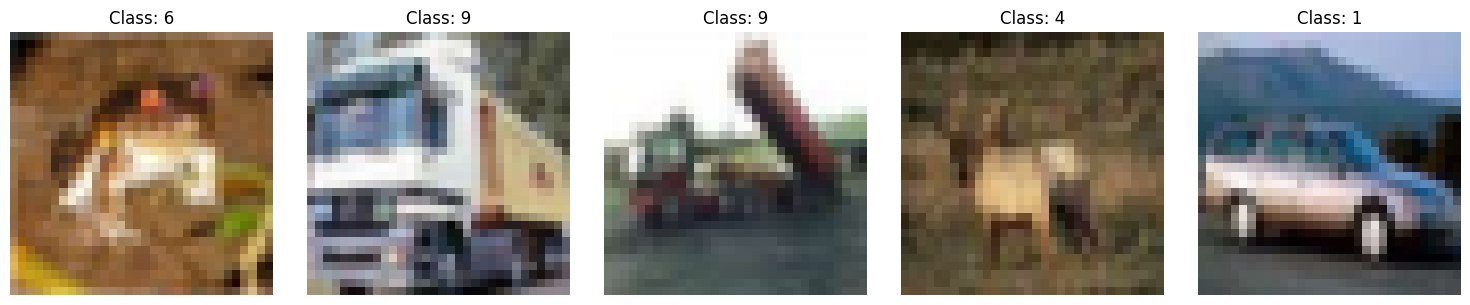

In [34]:
print(f"display training data with classes...")
display_image_data(X_train, y_train)

display validation data with classes...


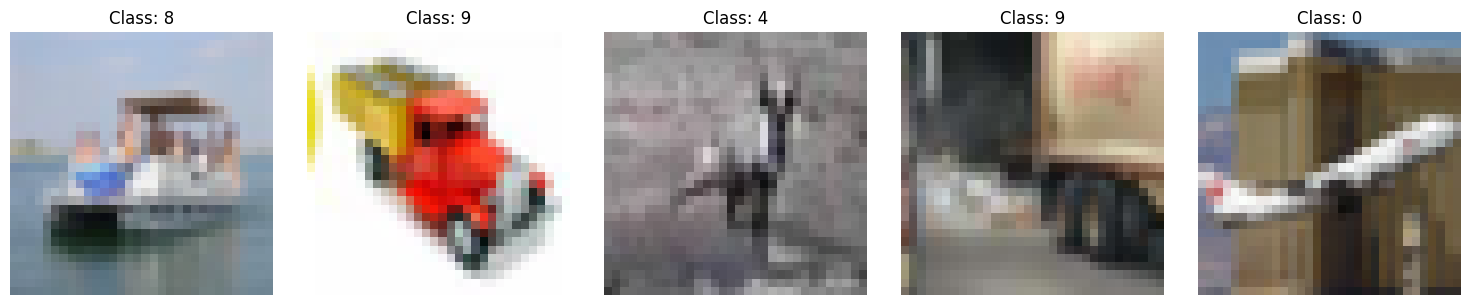

In [35]:
print(f"display validation data with classes...")
display_image_data(X_valid, y_valid)

display test data with classes...


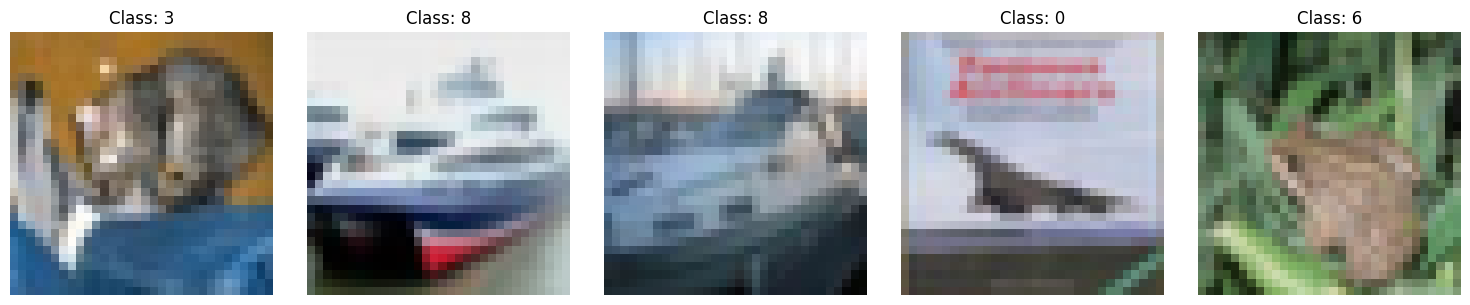

In [36]:
print(f"display test data with classes...")
display_image_data(X_test, y_test)

In [37]:
norm_X_train, norm_X_valid, norm_X_test = preprocess_data(
    X_train, X_valid, X_test
)

In [38]:
def compute_cyclical_learning_rate(t, eta_min, eta_max, n_s):
    # l - cycle counter. 1 cycle = 2 * ns
    l = np.floor(t / (2 * n_s))

    # calculate the learning rate for the first half of the cycle
    if 2 * l * n_s <= t <= (2 * l + 1) * n_s:
        return eta_min + ((t - 2 * l * n_s) / n_s) * (eta_max - eta_min)

        # calculate the learning rate for the second half of the cycle
    elif (2 * l + 1) * n_s <= t <= 2 * (l + 1) * n_s:
        return eta_max - ((t - (2 * l + 1) * n_s) / n_s) * (eta_max - eta_min)

In [39]:
def debug_trained_network(
    trained_net,
    MX_test,
):
    fp_test = apply_network(MX_test, trained_net)
    P_test = fp_test["P"]
    test_loss = compute_loss(P_test, y_test)
    test_accuracy = compute_accuracy(P_test, y_test)
    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f}")
    return test_loss, test_accuracy

In [40]:
def mini_batch_gd_cyclical(
    MX,
    Y,
    y,
    MX_val,
    y_val,
    GDparams,
    init_net,
    rng,
    label_smoothing=False,
    epsilon=0.1,
):
    # Deep copy to avoid modifying the original network
    trained_net = copy.deepcopy(init_net)
    n_batch = GDparams["n_batch"]
    lam = GDparams["lam"]

    # cyclical learning rate calculation
    eta_min = GDparams["eta_min"]
    eta_max = GDparams["eta_max"]
    n_cycles = GDparams["n_cycles"]
    step = GDparams[
        "step"
    ]  # step size - controls the number of steps to complete 1 cycle
    n_s = step

    # calculate number of epochs
    total_updates = n_cycles * 2 * n_s  # total number of updates
    n = MX.shape[2]  # number of images
    updates_per_epoch = n // n_batch
    n_epochs = int(np.ceil(total_updates / updates_per_epoch))
    print(f"total number of epochs: {n_epochs}")

    # record intermediary results
    # loss
    train_loss_output = []
    valid_loss_output = []
    # cost
    train_cost_output = []
    valid_cost_output = []
    # accuracy
    train_acc_output = []
    valid_acc_output = []

    # record t steps
    t_steps = []
    t_step = 0

    # training loop
    for epoch in range(n_epochs):
        # shuffle training data
        shuffle_indices = rng.permutation(n)
        MX_shuffled = MX[:, :, shuffle_indices]
        Y_shuffled = Y[:, shuffle_indices]
        y_shuffled = y[shuffle_indices]

        # batch processing
        # process n / n_batch images at a time
        for j in range(n // n_batch):
            j_start = j * n_batch
            j_end = (j + 1) * n_batch
            MX_batch = MX_shuffled[:, :, j_start:j_end]
            Y_batch = Y_shuffled[:, j_start:j_end]

            # compute learning rate and check epochs/cycle updtes
            t_step += 1
            if t_step > total_updates:
                break
            eta = compute_cyclical_learning_rate(t_step, eta_min, eta_max, n_s)

            # forward pass
            fp_batch = apply_network(MX_batch, trained_net)

            # backward pass + label smoothing
            if label_smoothing:
                grad_batch = backward_pass(
                    MX_batch,
                    Y_batch,
                    fp_batch,
                    trained_net,
                    lam,
                    True,
                    epsilon,
                )
            else:
                grad_batch = backward_pass(
                    MX_batch, Y_batch, fp_batch, trained_net, lam, False
                )

            # update parameters
            trained_net["Fs"] -= eta * grad_batch["Fs"]
            trained_net["Fs_b"] -= eta * grad_batch["Fs_b"]
            for i in range(len(trained_net["W"])):
                trained_net["W"][i] -= eta * grad_batch["W"][i]
                trained_net["b"][i] -= eta * grad_batch["b"][i]

        if t_step > total_updates:
            break

        # compute metrics after each epoch
        # training metrics
        fp_train = apply_network(MX, trained_net)
        P_train = fp_train["P"]
        # loss
        train_loss = compute_loss(P_train, y)
        train_loss_output.append(train_loss)
        # cost
        train_cost = compute_cost(P_train, y, trained_net, lam)
        train_cost_output.append(train_cost)
        # accuracy
        train_acc = compute_accuracy(P_train, y)
        train_acc_output.append(train_acc)

        # validation metrics
        fp_valid = apply_network(MX_val, trained_net)
        P_valid = fp_valid["P"]
        # loss
        valid_loss = compute_loss(P_valid, y_val)
        valid_loss_output.append(valid_loss)
        # cost
        valid_cost = compute_cost(P_valid, y_val, trained_net, lam)
        valid_cost_output.append(valid_cost)
        # accuracy
        valid_acc = compute_accuracy(P_valid, y_val)
        valid_acc_output.append(valid_acc)

        # t steps
        t_steps.append(t_step)

        print(
            f"Epoch {epoch + 1}/{n_epochs} | "
            f"Training Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f} | "
            f"Training Cost: {train_cost:.4f} | Validation Cost: {valid_cost:.4f} | "
            f"Training Accuracy: {train_acc:.4f} | Validation Accuracy: {valid_acc:.4f}"
        )

    print()
    return (
        trained_net,
        train_loss_output,
        valid_loss_output,
        train_cost_output,
        valid_cost_output,
        train_acc_output,
        valid_acc_output,
        t_steps,
    )

In [41]:
def mini_batch_gd_cyclical_increase_steps(
    MX,
    Y,
    y,
    MX_val,
    y_val,
    GDparams,
    init_net,
    rng,
    label_smoothing=False,
    epsilon=0.1,
):
    # Deep copy to avoid modifying the original network
    trained_net = copy.deepcopy(init_net)
    n_batch = GDparams["n_batch"]

    # cyclical learning rate calculation
    n_cycles = GDparams["n_cycles"]
    step = GDparams[
        "step"
    ]  # step size - controls the number of steps to complete 1 cycle
    total_updates = 0
    for cycle in range(n_cycles):
        cycle_steps = step * (2**cycle)
        total_updates += 2 * cycle_steps

    n = MX.shape[2]  # number of images
    updates_per_epoch = n // n_batch
    n_epochs = int(np.ceil(total_updates / updates_per_epoch))

    lam = GDparams["lam"]

    # cyclical learning rate
    eta_min = GDparams["eta_min"]  # min learning rate value
    eta_max = GDparams["eta_max"]  # max learning rate value

    # record intermediary results
    # loss
    train_loss_output = []
    valid_loss_output = []
    # cost
    train_cost_output = []
    valid_cost_output = []
    # accuracy
    train_acc_output = []
    valid_acc_output = []

    # record t steps
    t_steps = []
    t_step = 0

    # record cycle progression
    current_cycle = 0
    updates_in_current_cycle = 0
    current_cycle_steps = step

    # training loop
    for epoch in range(n_epochs):
        # shuffle data
        shuffle_indices = rng.permutation(n)
        MX_shuffled = MX[:, :, shuffle_indices]
        Y_shuffled = Y[:, shuffle_indices]
        y_shuffled = y[shuffle_indices]

        # batch processing
        for j in range(n // n_batch):
            j_start = j * n_batch
            j_end = (j + 1) * n_batch
            MX_batch = MX_shuffled[:, :, j_start:j_end]
            Y_batch = Y_shuffled[:, j_start:j_end]

            # compute learning rate
            t_step += 1
            updates_in_current_cycle += 1

            # check if current cycle has been completed
            if updates_in_current_cycle > 2 * current_cycle_steps:
                current_cycle += 1
                if current_cycle < n_cycles:
                    updates_in_current_cycle = 1
                    current_cycle_steps = step * (2**current_cycle)

            if current_cycle >= n_cycles:
                break

            n_s = current_cycle_steps
            eta = compute_cyclical_learning_rate(t_step, eta_min, eta_max, n_s)

            # compute passes
            fp_batch = apply_network(MX_batch, trained_net)  # forward pass

            # backward pass + label smoothing
            if label_smoothing:
                grad_batch = backward_pass(
                    MX_batch, Y_batch, fp_batch, trained_net, lam, True
                )  # backward pass
            else:
                grad_batch = backward_pass(
                    MX_batch, Y_batch, fp_batch, trained_net, lam, False
                )  # backward pass

            # update parameters
            trained_net["Fs"] -= eta * grad_batch["Fs"]  # convolution
            trained_net["Fs_b"] -= eta * grad_batch["Fs_b"]
            # weights and biases
            for i in range(len(trained_net["W"])):
                trained_net["W"][i] -= eta * grad_batch["W"][i]
                trained_net["b"][i] -= eta * grad_batch["b"][i]

        if current_cycle >= n_cycles:
            break

        # training metrics
        fp_train = apply_network(MX, trained_net)
        P_train = fp_train["P"]
        # loss
        train_loss = compute_loss(P_train, y)
        train_loss_output.append(train_loss)
        # cost
        train_cost = compute_cost(P_train, y, trained_net, lam)
        train_cost_output.append(train_cost)
        # accuracy
        train_acc = compute_accuracy(P_train, y)
        train_acc_output.append(train_acc)

        # validation metrics
        fp_valid = apply_network(MX_val, trained_net)
        P_valid = fp_valid["P"]
        # loss
        valid_loss = compute_loss(P_valid, y_val)
        valid_loss_output.append(valid_loss)
        # cost
        valid_cost = compute_cost(P_valid, y_val, trained_net, lam)
        valid_cost_output.append(valid_cost)
        # accuracy
        valid_acc = compute_accuracy(P_valid, y_val)
        valid_acc_output.append(valid_acc)

        t_steps.append(t_step)  # t-steps

        print(
            f"Epoch {epoch + 1}/{n_epochs} | "
            f"Training Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f} | "
            f"Training Cost: {train_cost:.4f} | Validation Cost: {valid_cost:.4f} | "
            f"Training Accuracy: {train_acc:.4f} | Validation Accuracy: {valid_acc:.4f}"
        )

    print()
    return (
        trained_net,
        train_loss_output,
        valid_loss_output,
        train_cost_output,
        valid_cost_output,
        train_acc_output,
        valid_acc_output,
        t_steps,
    )

In [42]:
def plot_cyclical_results(
    filename,
    train_loss_output,
    valid_loss_output,
    train_cost_output,
    valid_cost_output,
    train_acc_output,
    valid_acc_output,
    t_steps,
):
    # Create a figure with 2 rows and 3 columns
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    # loss plot
    axes[0, 0].plot(t_steps, train_loss_output, label="Training Loss")
    axes[0, 0].plot(t_steps, valid_loss_output, label="Validation Loss")
    axes[0, 0].set_xlabel("Update Step")
    axes[0, 0].set_ylabel("Loss")
    axes[0, 0].legend()
    axes[0, 0].set_title("Training and Validation Loss - Update Steps")
    axes[0, 0].grid(True)

    # cost plot
    axes[0, 1].plot(t_steps, train_cost_output, label="Training Cost")
    axes[0, 1].plot(t_steps, valid_cost_output, label="Validation Cost")
    axes[0, 1].set_xlabel("Update Step")
    axes[0, 1].set_ylabel("Cost")
    axes[0, 1].legend()
    axes[0, 1].set_title("Training and Validation Cost - Update Steps")
    axes[0, 1].grid(True)

    # accuracy plot
    axes[0, 2].plot(t_steps, train_acc_output, label="Training Accuracy")
    axes[0, 2].plot(t_steps, valid_acc_output, label="Validation Accuracy")
    axes[0, 2].set_xlabel("Update Step")
    axes[0, 2].set_ylabel("Accuracy")
    axes[0, 2].legend()
    axes[0, 2].set_title("Training and Validation Accuracy - Update Steps")
    axes[0, 2].grid(True)

    # loss plot
    axes[1, 0].plot(train_loss_output, label="Training Loss")
    axes[1, 0].plot(valid_loss_output, label="Validation Loss")
    axes[1, 0].set_xlabel("Epoch")
    axes[1, 0].set_ylabel("Loss")
    axes[1, 0].legend()
    axes[1, 0].set_title("Training and Validation Loss")
    axes[1, 0].grid(True)

    # cost plot
    axes[1, 1].plot(train_cost_output, label="Training Cost")
    axes[1, 1].plot(valid_cost_output, label="Validation Cost")
    axes[1, 1].set_xlabel("Epoch")
    axes[1, 1].set_ylabel("Cost")
    axes[1, 1].legend()
    axes[1, 1].set_title("Training and Validation Cost")
    axes[1, 1].grid(True)

    # accuracy plot
    axes[1, 2].plot(train_acc_output, label="Training Accuracy")
    axes[1, 2].plot(valid_acc_output, label="Validation Accuracy")
    axes[1, 2].set_xlabel("Epoch")
    axes[1, 2].set_ylabel("Accuracy")
    axes[1, 2].legend()
    axes[1, 2].set_title("Training and Validation Accuracy")
    axes[1, 2].grid(True)

    plt.tight_layout()
    if filename:
        plt.savefig(filename + "_results.png", dpi=300, bbox_inches="tight")
    plt.show()

In [43]:
def training_results(training_time, test_accuracy):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    architectures = list(training_time.keys())
    training_times = list(training_time.values())
    model_accuracy = list(test_accuracy.values())

    # Bar chart for training times
    ax1.bar(architectures, training_times)
    ax1.set_ylabel("Training Time (seconds)")
    ax1.set_title("Training Time by Architecture")
    ax1.tick_params(axis="x", rotation=45)
    ax1.set_xticklabels(architectures, rotation=45, ha="right")

    # Bar chart for test accuracies
    ax2.bar(architectures, model_accuracy)
    ax2.set_ylabel("Test Accuracy")
    ax2.set_title("Test Accuracy by Architecture")
    ax2.tick_params(axis="x", rotation=45)
    ax2.set_ylim(0, 1)
    ax2.set_xticklabels(architectures, rotation=45, ha="right")

    plt.tight_layout()
    plt.savefig("training_analysis.png", dpi=300, bbox_inches="tight")
    plt.show()

In [44]:
import time

# timing
training_time_result = {}
test_accuracy_result = {}

## Exercise 2 - Cyclical Experiments 

In [45]:
def run_cyclical_experiments(filename, GDparams, rng, label_smoothing=False):
    print(f"Run cyclical experiment...")
    print(f"filter size: {GDparams['f']}")
    print(f"number of filters: {GDparams['nf']}")
    print(f"number of neurons in hidden layer: {GDparams['nh']}")
    print(f"number of cycles: {GDparams['n_cycles']}")
    print(f"step size: {GDparams['step']}")
    print(f"eta_min: {GDparams['eta_min']}")
    print(f"eta_max: {GDparams['eta_max']}")
    print(f"batch size: {GDparams['n_batch']}")
    print(f"regularization: {GDparams['lam']}")
    print()

    print(f"transform normalized data for convolution...")
    X_train_conv = np.transpose(
        norm_X_train.reshape((32, 32, 3, norm_X_train.shape[1]), order="F"),
        (1, 0, 2, 3),
    )
    X_valid_conv = np.transpose(
        norm_X_valid.reshape((32, 32, 3, norm_X_valid.shape[1]), order="F"),
        (1, 0, 2, 3),
    )
    X_test_conv = np.transpose(
        norm_X_test.reshape((32, 32, 3, norm_X_test.shape[1]), order="F"),
        (1, 0, 2, 3),
    )
    print(f"finished transforming normalized data for convolution!!")
    print()

    # compute matrices for convolution
    print(f"compute matrices for convolution...")
    MX_train = init_matrix_convolution(
        X_train_conv, GDparams["f"], norm_X_train.shape[1]
    )
    MX_val = init_matrix_convolution(
        X_valid_conv, GDparams["f"], norm_X_valid.shape[1]
    )
    MX_test = init_matrix_convolution(
        X_test_conv, GDparams["f"], norm_X_test.shape[1]
    )
    print(f"finished computing matrices for convolution!!")
    print()

    # initialize network
    print(f"initialize network...")
    init_net = initialize_network(
        GDparams["f"], GDparams["nf"], GDparams["nh"], 10, rng
    )
    print(f"finished initializing network!!")
    print()

    # train model
    print(f"train the network...")
    start_time = time.time()
    (
        trained_net,
        train_loss_output,
        valid_loss_output,
        train_cost_output,
        valid_cost_output,
        train_acc_output,
        valid_acc_output,
        t_steps,
    ) = mini_batch_gd_cyclical(
        MX_train,
        Y_train,
        y_train,
        MX_val,
        y_valid,
        GDparams,
        init_net,
        rng,
        label_smoothing,
        epsilon=0.1,
    )
    end_time = time.time()
    training_time = end_time - start_time
    print(f"finished training network!!")
    print(f"Training time: {training_time:.2f} seconds")
    print()
    print(f"Test trained neural network against ground truth...")
    test_loss, test_accuracy = debug_trained_network(trained_net, MX_test)
    print(f"Test loss: {test_loss:.2f} | Test accuracy: {test_accuracy:.2f}")
    print()
    training_time_result[filename] = training_time
    test_accuracy_result[filename] = test_accuracy
    print(f"Plot loss and accuracy...")
    plot_cyclical_results(
        filename,
        train_loss_output,
        valid_loss_output,
        train_cost_output,
        valid_cost_output,
        train_acc_output,
        valid_acc_output,
        t_steps,
    )

In [46]:
def run_cyclical_experiments_increase_steps(
    filename, GDparams, rng, label_smoothing=False
):
    print(f"Run cyclical experiment with increasing steps...")
    print(f"filter size: {GDparams['f']}")
    print(f"number of filters: {GDparams['nf']}")
    print(f"number of neurons in hidden layer: {GDparams['nh']}")
    print(f"number of cycles: {GDparams['n_cycles']}")
    print(f"initial_step size: {GDparams['step']}")
    print(f"eta_min: {GDparams['eta_min']}")
    print(f"eta_max: {GDparams['eta_max']}")
    print(f"batch size: {GDparams['n_batch']}")
    print(f"regularization: {GDparams['lam']}")
    print()

    print(f"transform normalized data for convolution...")
    X_train_conv = np.transpose(
        norm_X_train.reshape((32, 32, 3, norm_X_train.shape[1]), order="F"),
        (1, 0, 2, 3),
    )
    X_valid_conv = np.transpose(
        norm_X_valid.reshape((32, 32, 3, norm_X_valid.shape[1]), order="F"),
        (1, 0, 2, 3),
    )
    X_test_conv = np.transpose(
        norm_X_test.reshape((32, 32, 3, norm_X_test.shape[1]), order="F"),
        (1, 0, 2, 3),
    )
    print(f"finished transforming normalized data for convolution!!")
    print()

    # compute matrices for convolution
    print(f"compute matrices for convolution...")
    MX_train = init_matrix_convolution(
        X_train_conv, GDparams["f"], norm_X_train.shape[1]
    )
    MX_val = init_matrix_convolution(
        X_valid_conv, GDparams["f"], norm_X_valid.shape[1]
    )
    MX_test = init_matrix_convolution(
        X_test_conv, GDparams["f"], norm_X_test.shape[1]
    )
    print(f"finished computing matrices for convolution!!")
    print()

    # initialize network
    print(f"initialize network...")
    init_net = initialize_network(
        GDparams["f"], GDparams["nf"], GDparams["nh"], 10, rng
    )
    print(f"finished initializing network!!")
    print()

    # train model
    print(f"train the network...")
    start_time = time.time()
    (
        trained_net,
        train_loss_output,
        valid_loss_output,
        train_cost_output,
        valid_cost_output,
        train_acc_output,
        valid_acc_output,
        t_steps,
    ) = mini_batch_gd_cyclical_increase_steps(
        MX_train,
        Y_train,
        y_train,
        MX_val,
        y_valid,
        GDparams,
        init_net,
        rng,
        label_smoothing,
        epsilon=0.1,
    )
    end_time = time.time()
    training_time = end_time - start_time
    print(f"finished training network!!")
    print(f"Training time: {training_time:.2f} seconds")
    print()
    print(f"Test trained neural network against ground truth...")
    test_loss, test_accuracy = debug_trained_network(trained_net, MX_test)
    print(f"Test loss: {test_loss:.2f}, Test accuracy: {test_accuracy:.2f}")
    print()
    training_time_result[filename] = training_time
    test_accuracy_result[filename] = test_accuracy
    print()
    print(f"Plot loss and accuracy...")
    plot_cyclical_results(
        filename,
        train_loss_output,
        valid_loss_output,
        train_cost_output,
        valid_cost_output,
        train_acc_output,
        valid_acc_output,
        t_steps,
    )

## Exercise 3 - Neural Networks go brrrrr......

In [47]:
def test_experiment1():
    GDparams = {
        "f": 4,
        "nf": 10,
        "nh": 50,
        "n_cycles": 3,
        "step": 800,
        "eta_min": 1e-5,
        "eta_max": 1e-1,
        "n_batch": 100,
        "lam": 0.003,
    }
    # set up random number generator for reproducibility
    rng = np.random.default_rng(42)

    run_cyclical_experiments("architecture-2-init", GDparams, rng, False)

Run cyclical experiment...
filter size: 4
number of filters: 10
number of neurons in hidden layer: 50
number of cycles: 3
step size: 800
eta_min: 1e-05
eta_max: 0.1
batch size: 100
regularization: 0.003

transform normalized data for convolution...
finished transforming normalized data for convolution!!

compute matrices for convolution...
finished computing matrices for convolution!!

initialize network...
finished initializing network!!

train the network...
total number of epochs: 10
Epoch 1/10 | Training Loss: 1.6532 | Validation Loss: 1.6922 | Training Cost: 2.0082 | Validation Cost: 2.0473 | Training Accuracy: 0.4106 | Validation Accuracy: 0.4250
Epoch 2/10 | Training Loss: 1.4212 | Validation Loss: 1.4501 | Training Cost: 1.6772 | Validation Cost: 1.7061 | Training Accuracy: 0.4905 | Validation Accuracy: 0.4710
Epoch 3/10 | Training Loss: 1.2939 | Validation Loss: 1.3459 | Training Cost: 1.5147 | Validation Cost: 1.5667 | Training Accuracy: 0.5424 | Validation Accuracy: 0.5320
E

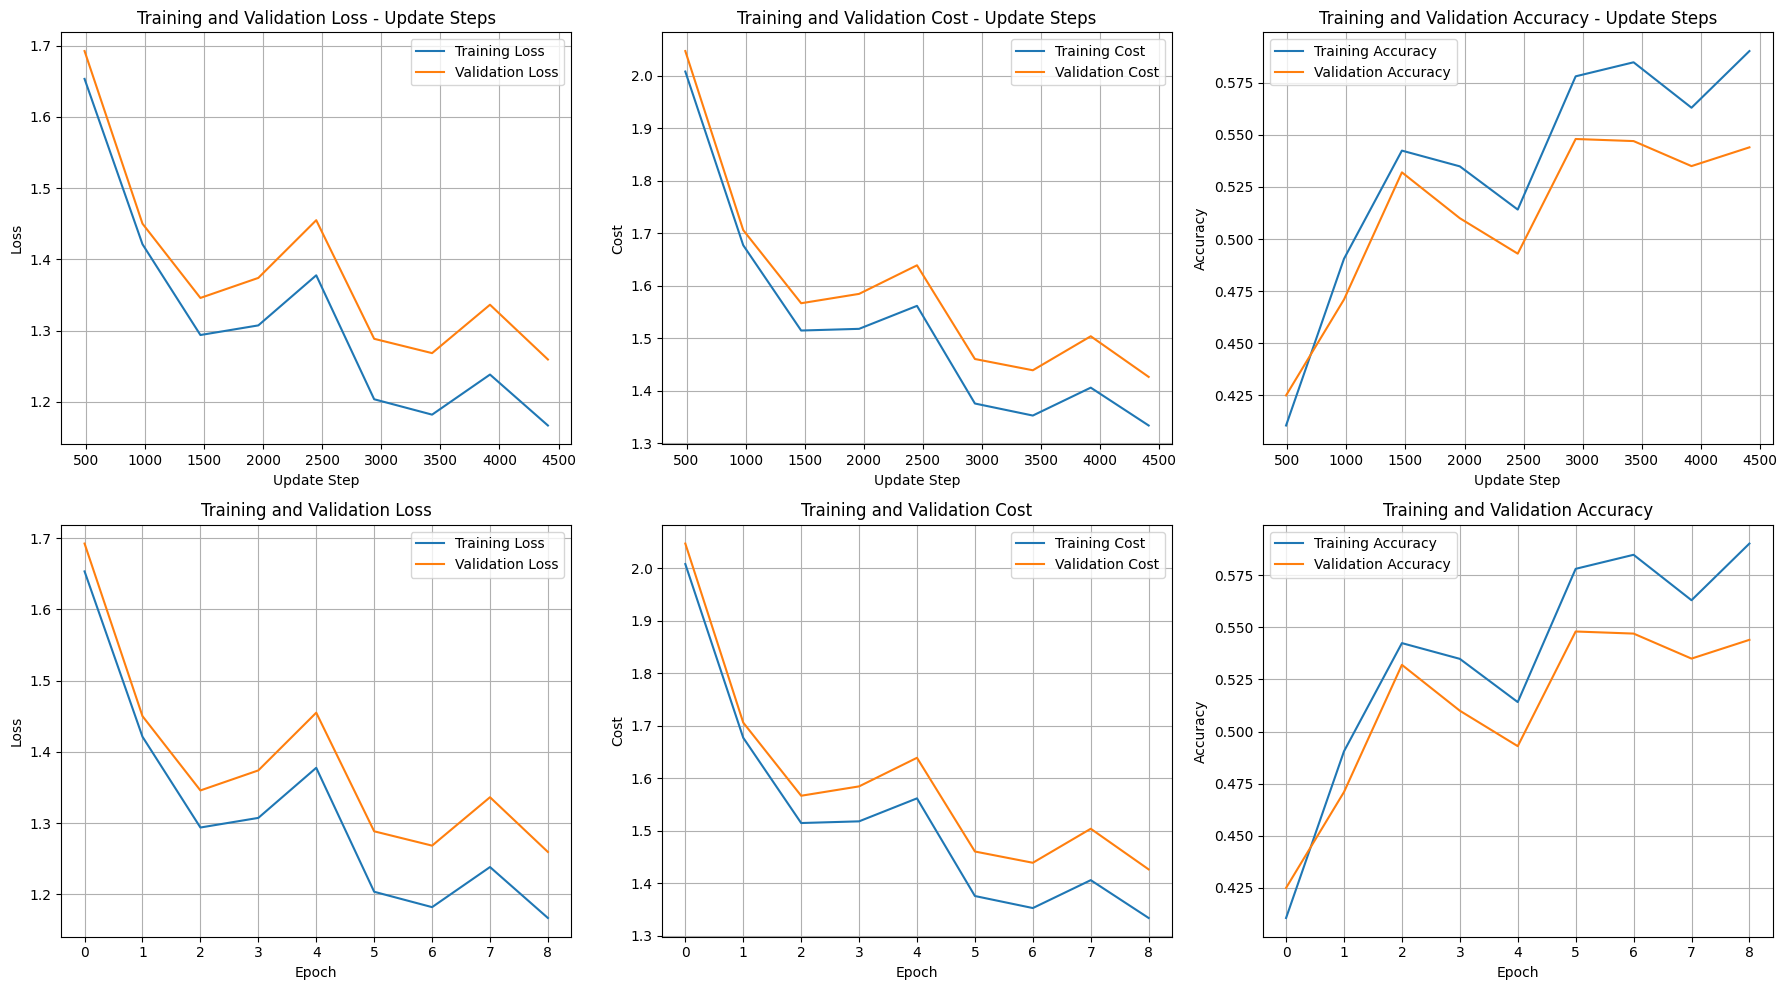

In [48]:
test_experiment1()

In [49]:
def experiment1():
    GDparams = {
        "f": 2,
        "nf": 3,
        "nh": 50,
        "n_cycles": 3,
        "step": 800,
        "eta_min": 1e-5,
        "eta_max": 1e-1,
        "n_batch": 100,
        "lam": 0.003,
    }
    # set up random number generator for reproducibility
    rng = np.random.default_rng(42)

    run_cyclical_experiments("architecture-1", GDparams, rng, False)

Run cyclical experiment...
filter size: 2
number of filters: 3
number of neurons in hidden layer: 50
number of cycles: 3
step size: 800
eta_min: 1e-05
eta_max: 0.1
batch size: 100
regularization: 0.003

transform normalized data for convolution...
finished transforming normalized data for convolution!!

compute matrices for convolution...
finished computing matrices for convolution!!

initialize network...
finished initializing network!!

train the network...
total number of epochs: 10
Epoch 1/10 | Training Loss: 1.7534 | Validation Loss: 1.7641 | Training Cost: 2.0767 | Validation Cost: 2.0874 | Training Accuracy: 0.3850 | Validation Accuracy: 0.3730
Epoch 2/10 | Training Loss: 1.5545 | Validation Loss: 1.5594 | Training Cost: 1.7868 | Validation Cost: 1.7917 | Training Accuracy: 0.4558 | Validation Accuracy: 0.4630
Epoch 3/10 | Training Loss: 1.4617 | Validation Loss: 1.4842 | Training Cost: 1.6618 | Validation Cost: 1.6844 | Training Accuracy: 0.4878 | Validation Accuracy: 0.4670
Ep

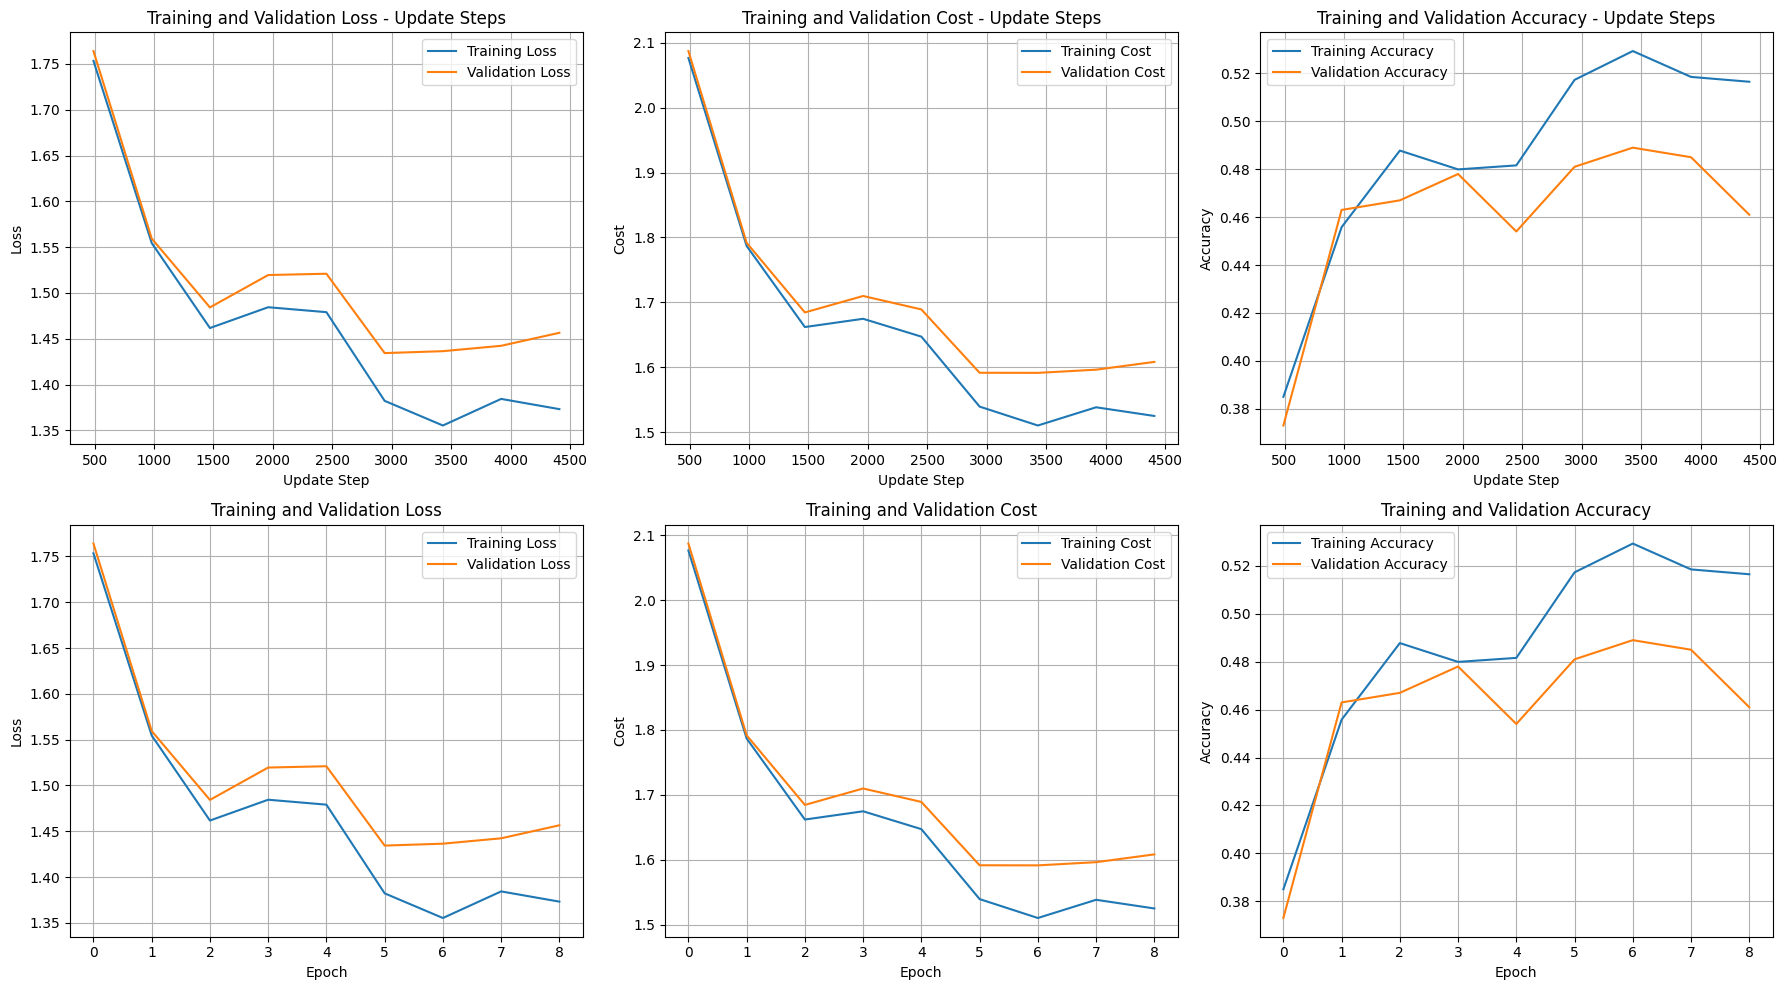

In [50]:
experiment1()

In [51]:
def experiment2():
    GDparams = {
        "f": 4,
        "nf": 10,
        "nh": 50,
        "n_cycles": 3,
        "step": 800,
        "eta_min": 1e-5,
        "eta_max": 1e-1,
        "n_batch": 100,
        "lam": 0.003,
    }
    # set up random number generator for reproducibility
    rng = np.random.default_rng(42)

    run_cyclical_experiments("architecture-2", GDparams, rng, False)

Run cyclical experiment...
filter size: 4
number of filters: 10
number of neurons in hidden layer: 50
number of cycles: 3
step size: 800
eta_min: 1e-05
eta_max: 0.1
batch size: 100
regularization: 0.003

transform normalized data for convolution...
finished transforming normalized data for convolution!!

compute matrices for convolution...
finished computing matrices for convolution!!

initialize network...
finished initializing network!!

train the network...
total number of epochs: 10
Epoch 1/10 | Training Loss: 1.6532 | Validation Loss: 1.6922 | Training Cost: 2.0082 | Validation Cost: 2.0473 | Training Accuracy: 0.4106 | Validation Accuracy: 0.4250
Epoch 2/10 | Training Loss: 1.4212 | Validation Loss: 1.4501 | Training Cost: 1.6772 | Validation Cost: 1.7061 | Training Accuracy: 0.4905 | Validation Accuracy: 0.4710
Epoch 3/10 | Training Loss: 1.2939 | Validation Loss: 1.3459 | Training Cost: 1.5147 | Validation Cost: 1.5667 | Training Accuracy: 0.5424 | Validation Accuracy: 0.5320
E

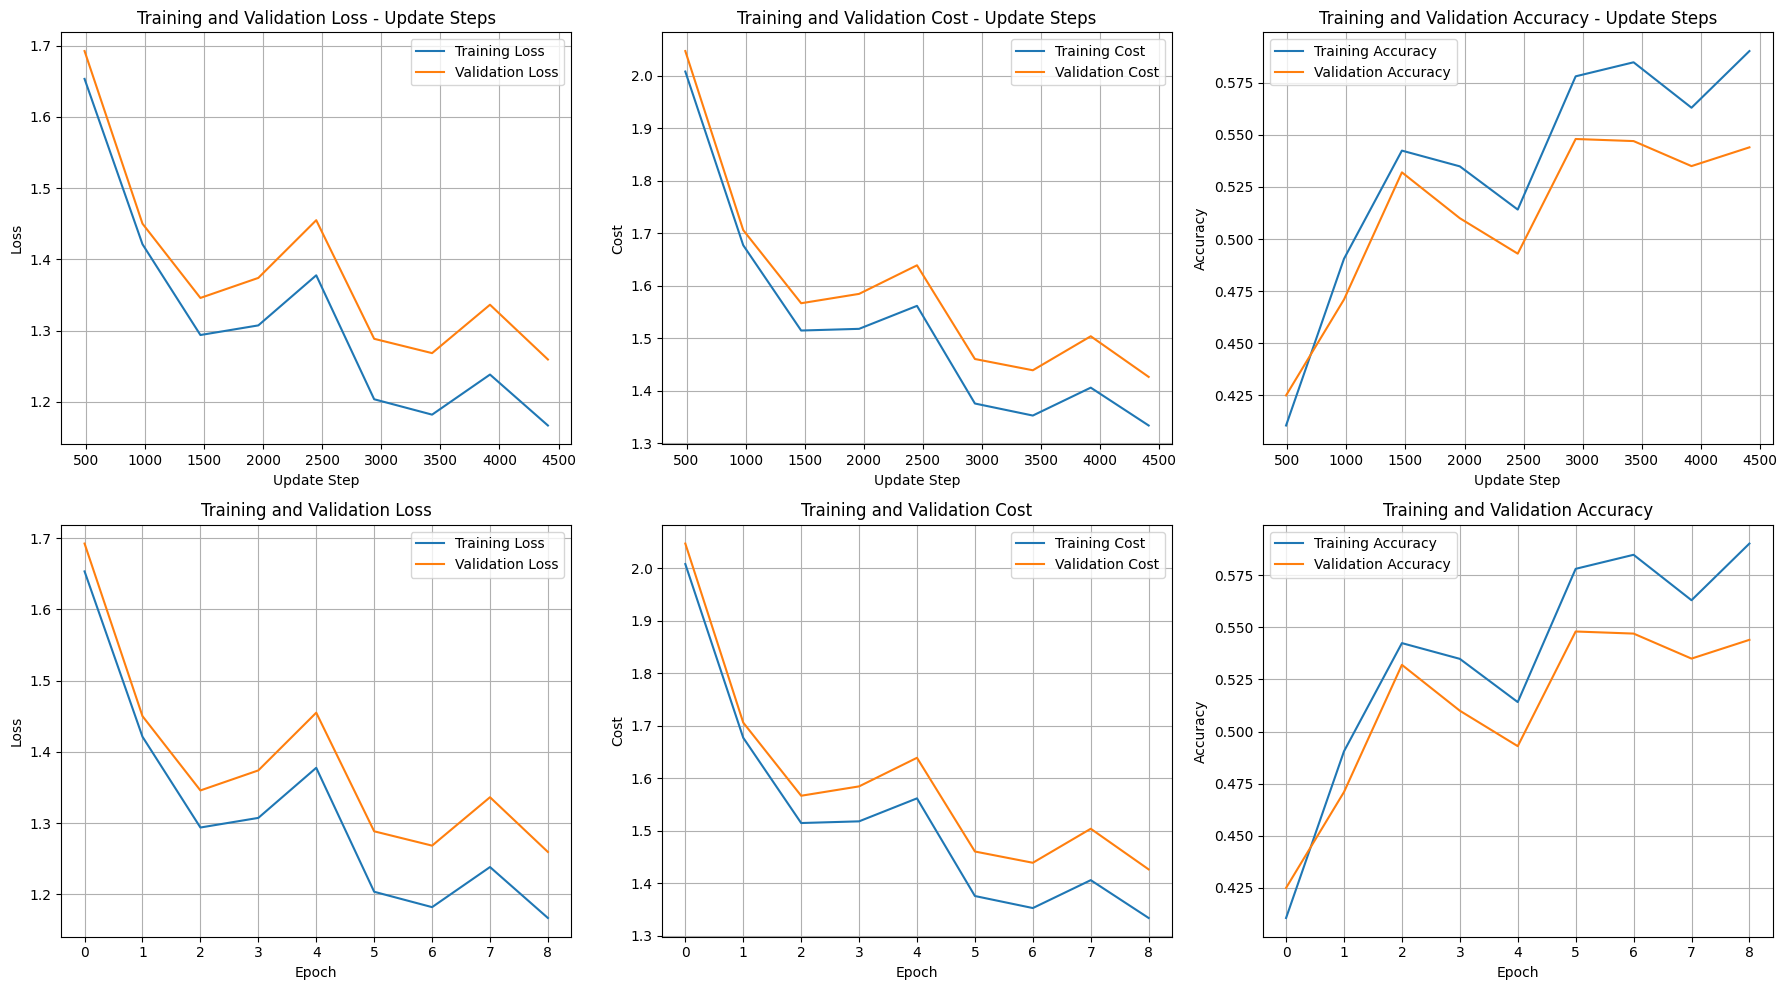

In [52]:
experiment2()

In [53]:
def experiment3():
    GDparams = {
        "f": 8,
        "nf": 40,
        "nh": 50,
        "n_cycles": 3,
        "step": 800,
        "eta_min": 1e-5,
        "eta_max": 1e-1,
        "n_batch": 100,
        "lam": 0.003,
    }
    # set up random number generator for reproducibility
    rng = np.random.default_rng(42)

    run_cyclical_experiments("architecture-3", GDparams, rng, False)

Run cyclical experiment...
filter size: 8
number of filters: 40
number of neurons in hidden layer: 50
number of cycles: 3
step size: 800
eta_min: 1e-05
eta_max: 0.1
batch size: 100
regularization: 0.003

transform normalized data for convolution...
finished transforming normalized data for convolution!!

compute matrices for convolution...
finished computing matrices for convolution!!

initialize network...
finished initializing network!!

train the network...
total number of epochs: 10
Epoch 1/10 | Training Loss: 1.6196 | Validation Loss: 1.6105 | Training Cost: 2.1289 | Validation Cost: 2.1199 | Training Accuracy: 0.4266 | Validation Accuracy: 0.4350
Epoch 2/10 | Training Loss: 1.4091 | Validation Loss: 1.4195 | Training Cost: 1.7601 | Validation Cost: 1.7704 | Training Accuracy: 0.5042 | Validation Accuracy: 0.4990
Epoch 3/10 | Training Loss: 1.2766 | Validation Loss: 1.3116 | Training Cost: 1.5754 | Validation Cost: 1.6104 | Training Accuracy: 0.5541 | Validation Accuracy: 0.5310
E

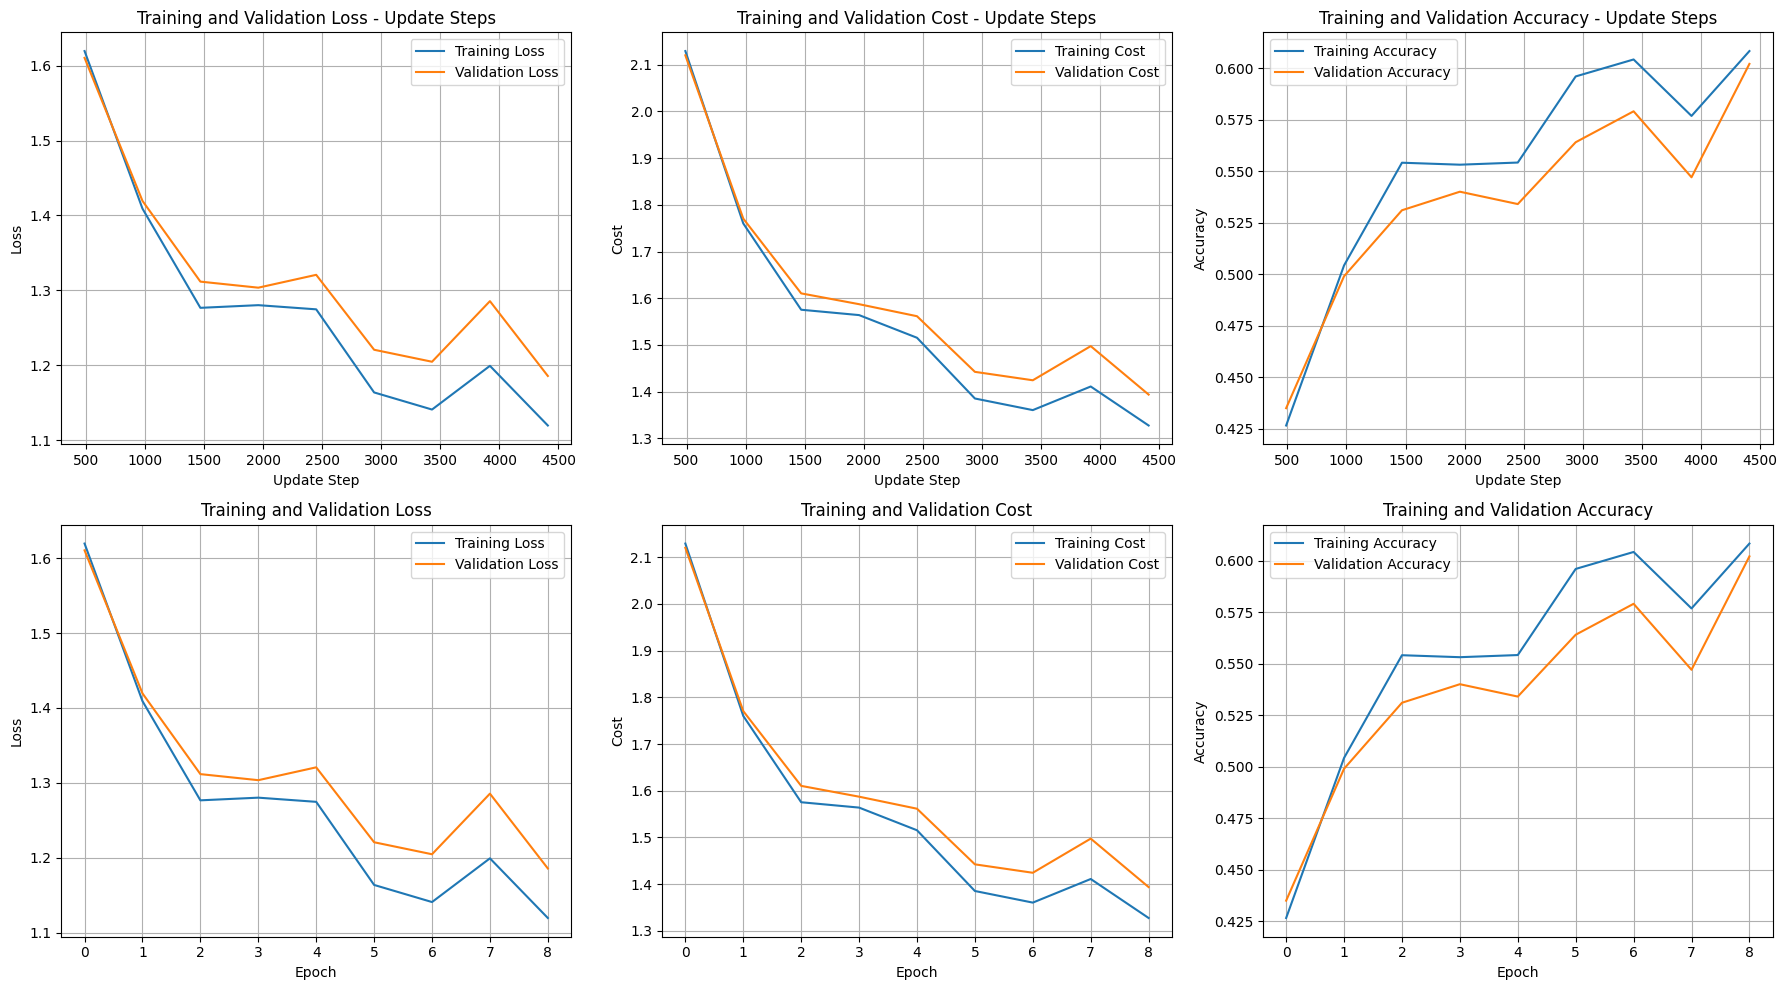

In [54]:
experiment3()

In [55]:
def experiment4():
    GDparams = {
        "f": 16,
        "nf": 160,
        "nh": 50,
        "n_cycles": 3,
        "step": 800,
        "eta_min": 1e-5,
        "eta_max": 1e-1,
        "n_batch": 100,
        "lam": 0.003,
    }
    # set up random number generator for reproducibility
    rng = np.random.default_rng(42)

    run_cyclical_experiments("architecture-4", GDparams, rng, False)

Run cyclical experiment...
filter size: 16
number of filters: 160
number of neurons in hidden layer: 50
number of cycles: 3
step size: 800
eta_min: 1e-05
eta_max: 0.1
batch size: 100
regularization: 0.003

transform normalized data for convolution...
finished transforming normalized data for convolution!!

compute matrices for convolution...
finished computing matrices for convolution!!

initialize network...
finished initializing network!!

train the network...
total number of epochs: 10
Epoch 1/10 | Training Loss: 1.5895 | Validation Loss: 1.6304 | Training Cost: 2.7019 | Validation Cost: 2.7428 | Training Accuracy: 0.4373 | Validation Accuracy: 0.4360
Epoch 2/10 | Training Loss: 1.4506 | Validation Loss: 1.4984 | Training Cost: 2.1783 | Validation Cost: 2.2262 | Training Accuracy: 0.4913 | Validation Accuracy: 0.4760
Epoch 3/10 | Training Loss: 1.2861 | Validation Loss: 1.3438 | Training Cost: 1.8764 | Validation Cost: 1.9341 | Training Accuracy: 0.5489 | Validation Accuracy: 0.5270

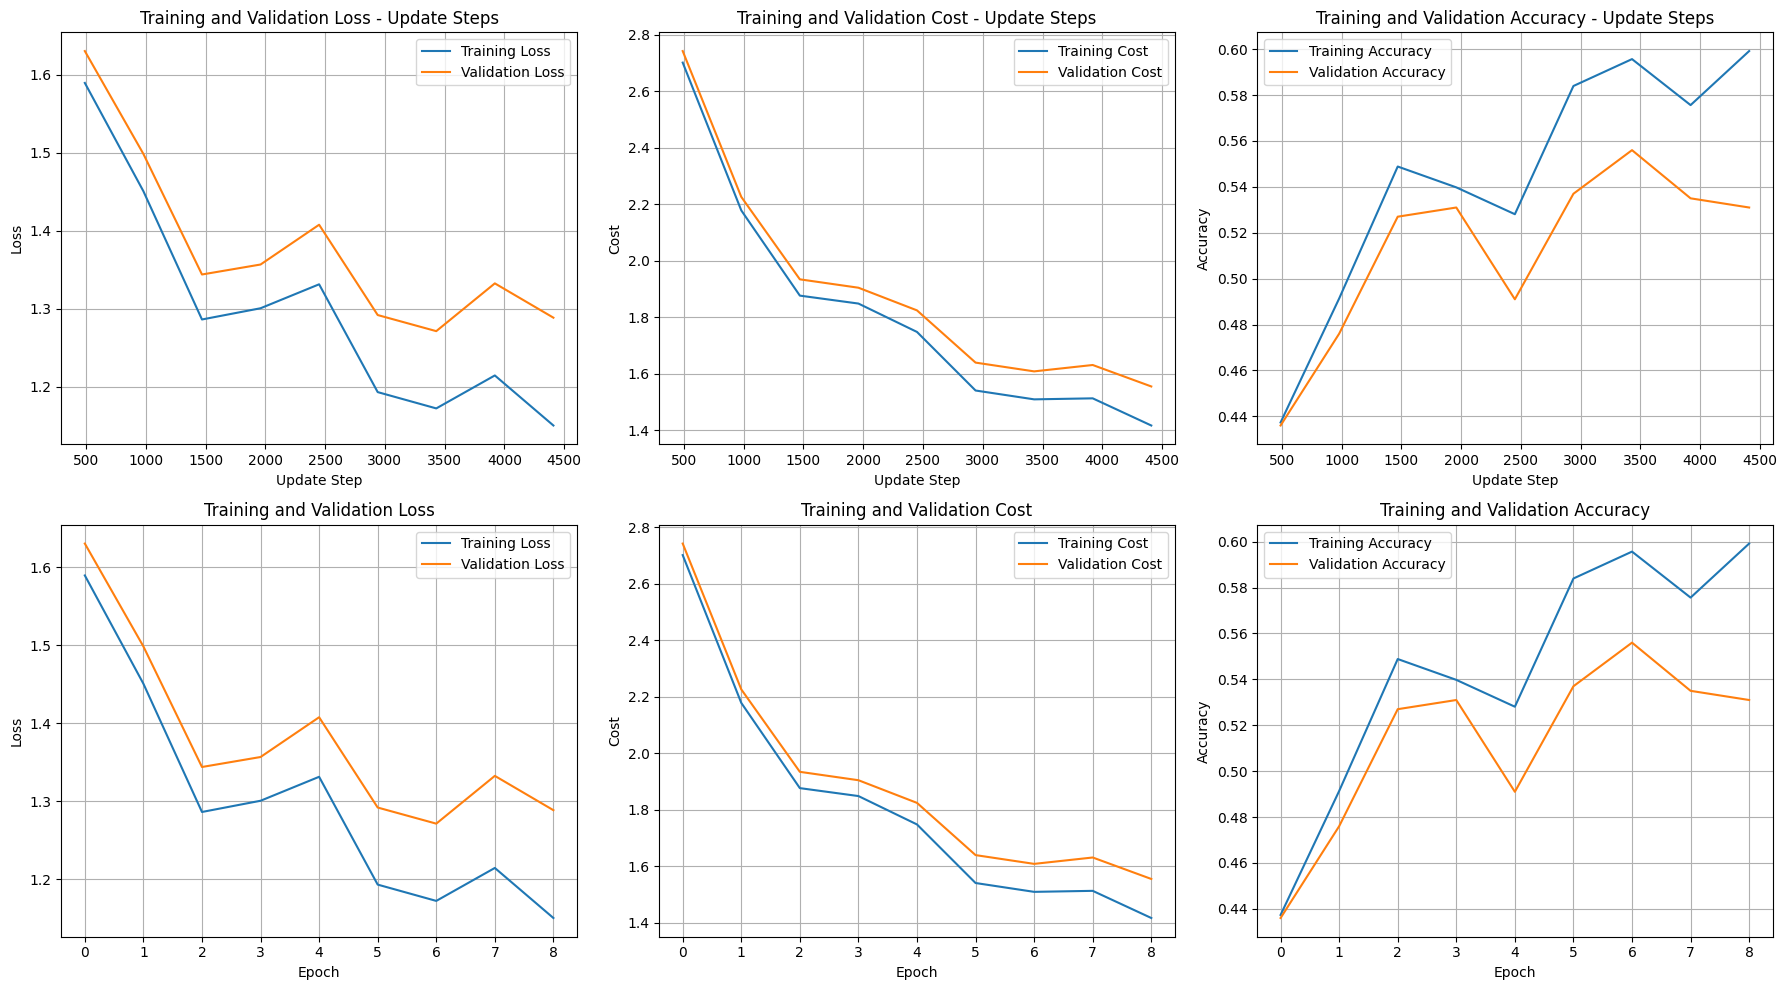

In [56]:
experiment4()

In [57]:
def arch2_experiment1():
    GDparams = {
        "f": 4,
        "nf": 10,
        "nh": 50,
        "n_cycles": 3,
        "step": 800,
        "eta_min": 1e-5,
        "eta_max": 1e-1,
        "n_batch": 100,
        "lam": 0.003,
    }
    # set up random number generator for reproducibility
    rng = np.random.default_rng(42)

    run_cyclical_experiments_increase_steps(
        "train-longer-architecture-2", GDparams, rng, False
    )

Run cyclical experiment with increasing steps...
filter size: 4
number of filters: 10
number of neurons in hidden layer: 50
number of cycles: 3
initial_step size: 800
eta_min: 1e-05
eta_max: 0.1
batch size: 100
regularization: 0.003

transform normalized data for convolution...
finished transforming normalized data for convolution!!

compute matrices for convolution...
finished computing matrices for convolution!!

initialize network...
finished initializing network!!

train the network...
Epoch 1/23 | Training Loss: 1.6532 | Validation Loss: 1.6922 | Training Cost: 2.0082 | Validation Cost: 2.0473 | Training Accuracy: 0.4106 | Validation Accuracy: 0.4250
Epoch 2/23 | Training Loss: 1.4212 | Validation Loss: 1.4501 | Training Cost: 1.6772 | Validation Cost: 1.7061 | Training Accuracy: 0.4905 | Validation Accuracy: 0.4710
Epoch 3/23 | Training Loss: 1.2939 | Validation Loss: 1.3459 | Training Cost: 1.5147 | Validation Cost: 1.5667 | Training Accuracy: 0.5424 | Validation Accuracy: 0.532

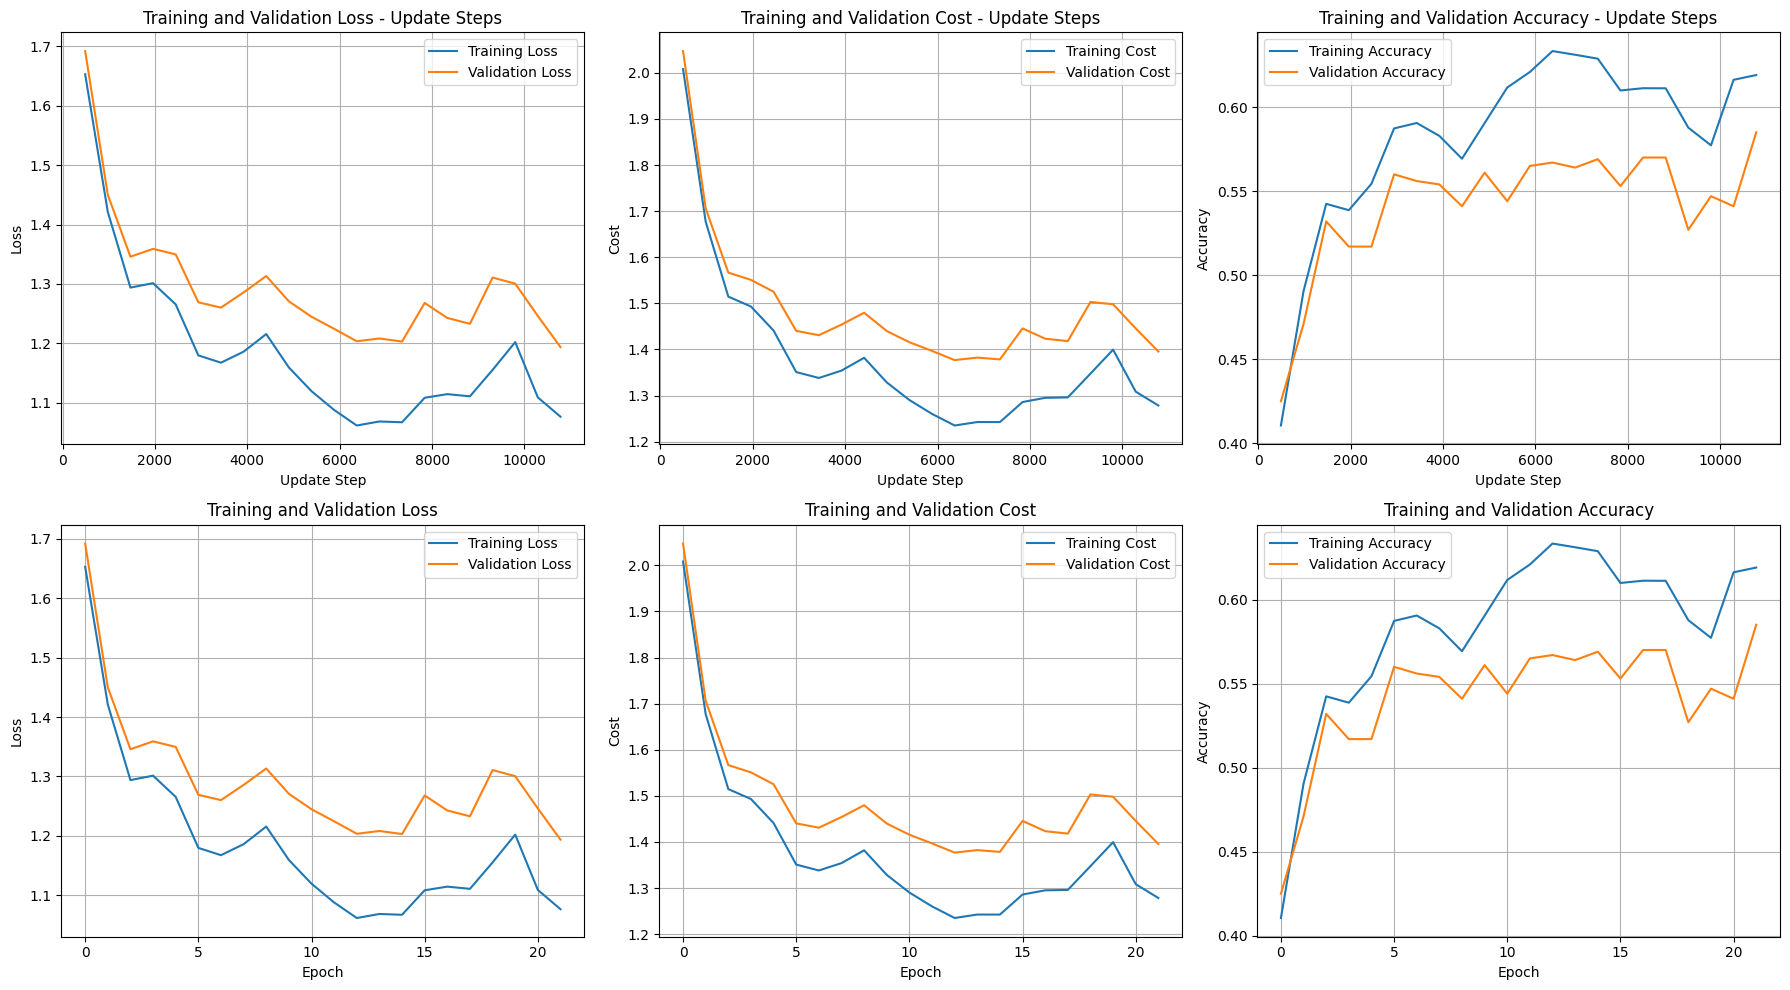

In [58]:
arch2_experiment1()

In [59]:
def arch3_experiment():
    GDparams = {
        "f": 8,
        "nf": 40,
        "nh": 50,
        "n_cycles": 3,
        "step": 800,
        "eta_min": 1e-5,
        "eta_max": 1e-1,
        "n_batch": 100,
        "lam": 0.003,
    }
    # set up random number generator for reproducibility
    rng = np.random.default_rng(42)

    run_cyclical_experiments_increase_steps(
        "train-longer-architecture-3", GDparams, rng, False
    )

Run cyclical experiment with increasing steps...
filter size: 8
number of filters: 40
number of neurons in hidden layer: 50
number of cycles: 3
initial_step size: 800
eta_min: 1e-05
eta_max: 0.1
batch size: 100
regularization: 0.003

transform normalized data for convolution...
finished transforming normalized data for convolution!!

compute matrices for convolution...
finished computing matrices for convolution!!

initialize network...
finished initializing network!!

train the network...
Epoch 1/23 | Training Loss: 1.6196 | Validation Loss: 1.6105 | Training Cost: 2.1289 | Validation Cost: 2.1199 | Training Accuracy: 0.4266 | Validation Accuracy: 0.4350
Epoch 2/23 | Training Loss: 1.4091 | Validation Loss: 1.4195 | Training Cost: 1.7601 | Validation Cost: 1.7704 | Training Accuracy: 0.5042 | Validation Accuracy: 0.4990
Epoch 3/23 | Training Loss: 1.2766 | Validation Loss: 1.3116 | Training Cost: 1.5754 | Validation Cost: 1.6104 | Training Accuracy: 0.5541 | Validation Accuracy: 0.531

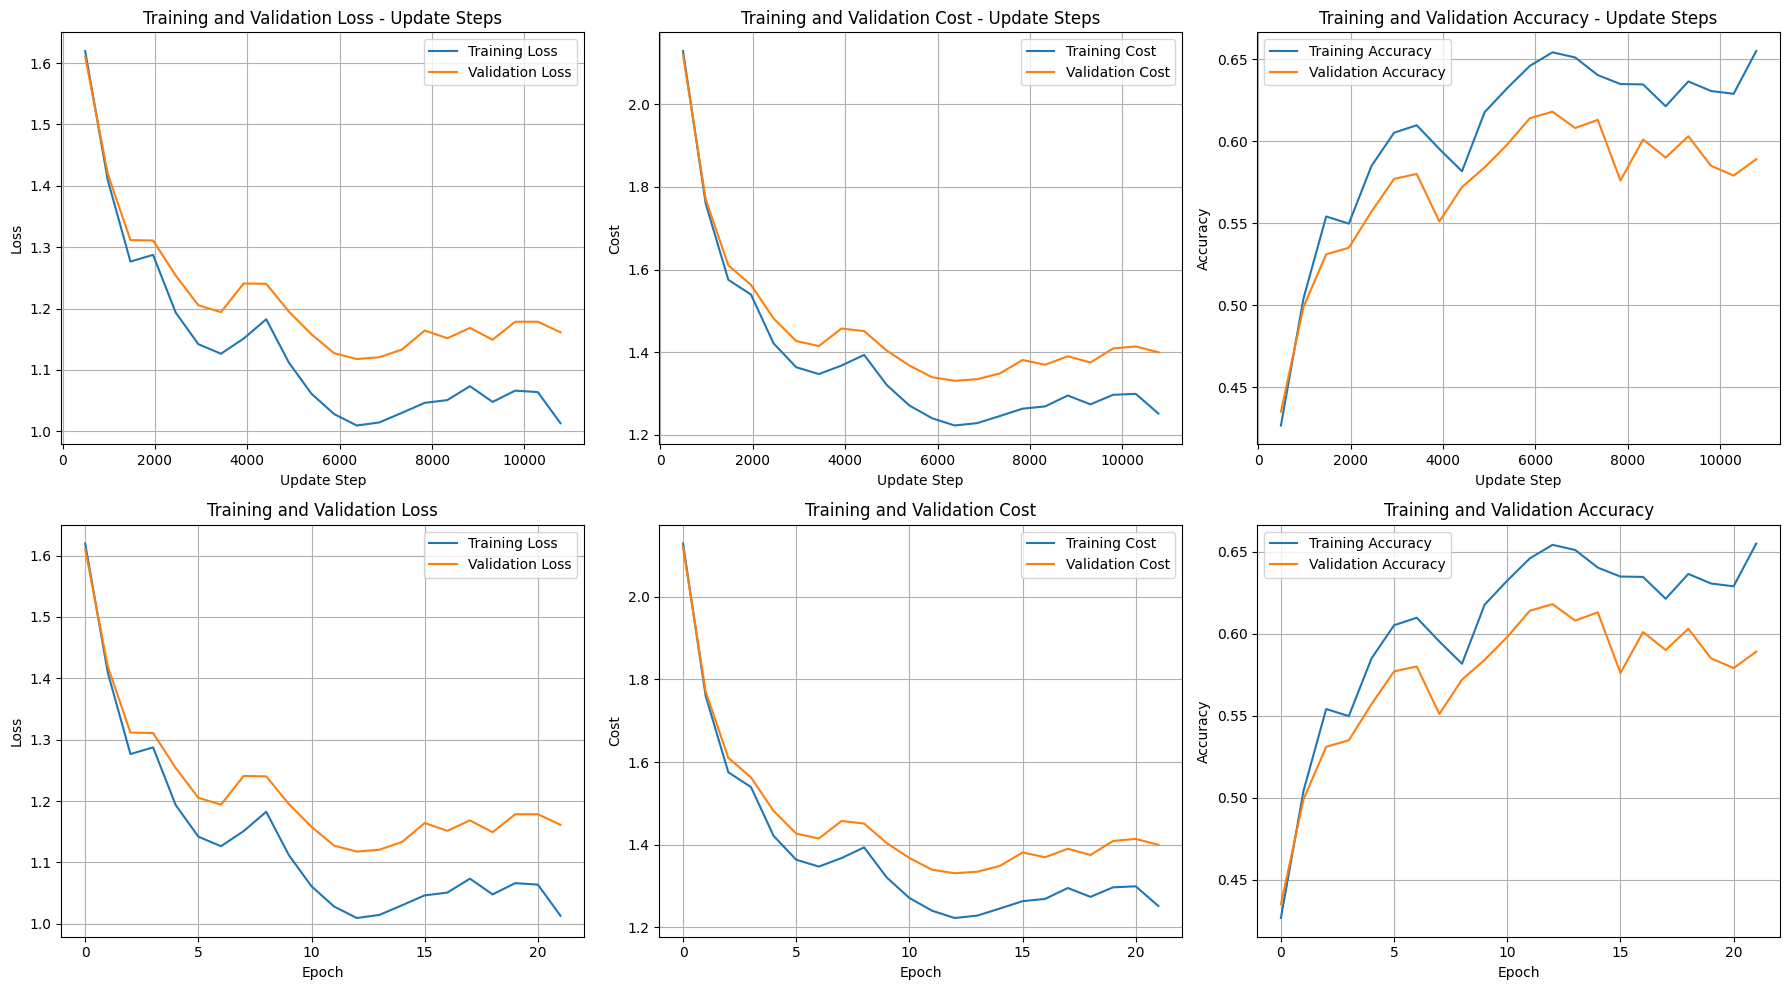

In [60]:
arch3_experiment()

In [61]:
def arch2_experiment2():
    GDparams = {
        "f": 4,
        "nf": 40,
        "nh": 50,
        "n_cycles": 3,
        "step": 800,
        "eta_min": 1e-5,
        "eta_max": 1e-1,
        "n_batch": 100,
        "lam": 0.003,
    }
    # set up random number generator for reproducibility
    rng = np.random.default_rng(42)

    run_cyclical_experiments_increase_steps(
        "train-longer-update-architecture-2", GDparams, rng, False
    )

Run cyclical experiment with increasing steps...
filter size: 4
number of filters: 40
number of neurons in hidden layer: 50
number of cycles: 3
initial_step size: 800
eta_min: 1e-05
eta_max: 0.1
batch size: 100
regularization: 0.003

transform normalized data for convolution...
finished transforming normalized data for convolution!!

compute matrices for convolution...
finished computing matrices for convolution!!

initialize network...
finished initializing network!!

train the network...
Epoch 1/23 | Training Loss: 1.5019 | Validation Loss: 1.5410 | Training Cost: 2.0173 | Validation Cost: 2.0564 | Training Accuracy: 0.4668 | Validation Accuracy: 0.4560
Epoch 2/23 | Training Loss: 1.2619 | Validation Loss: 1.3283 | Training Cost: 1.6384 | Validation Cost: 1.7048 | Training Accuracy: 0.5548 | Validation Accuracy: 0.5290
Epoch 3/23 | Training Loss: 1.1288 | Validation Loss: 1.2263 | Training Cost: 1.4610 | Validation Cost: 1.5585 | Training Accuracy: 0.6079 | Validation Accuracy: 0.578

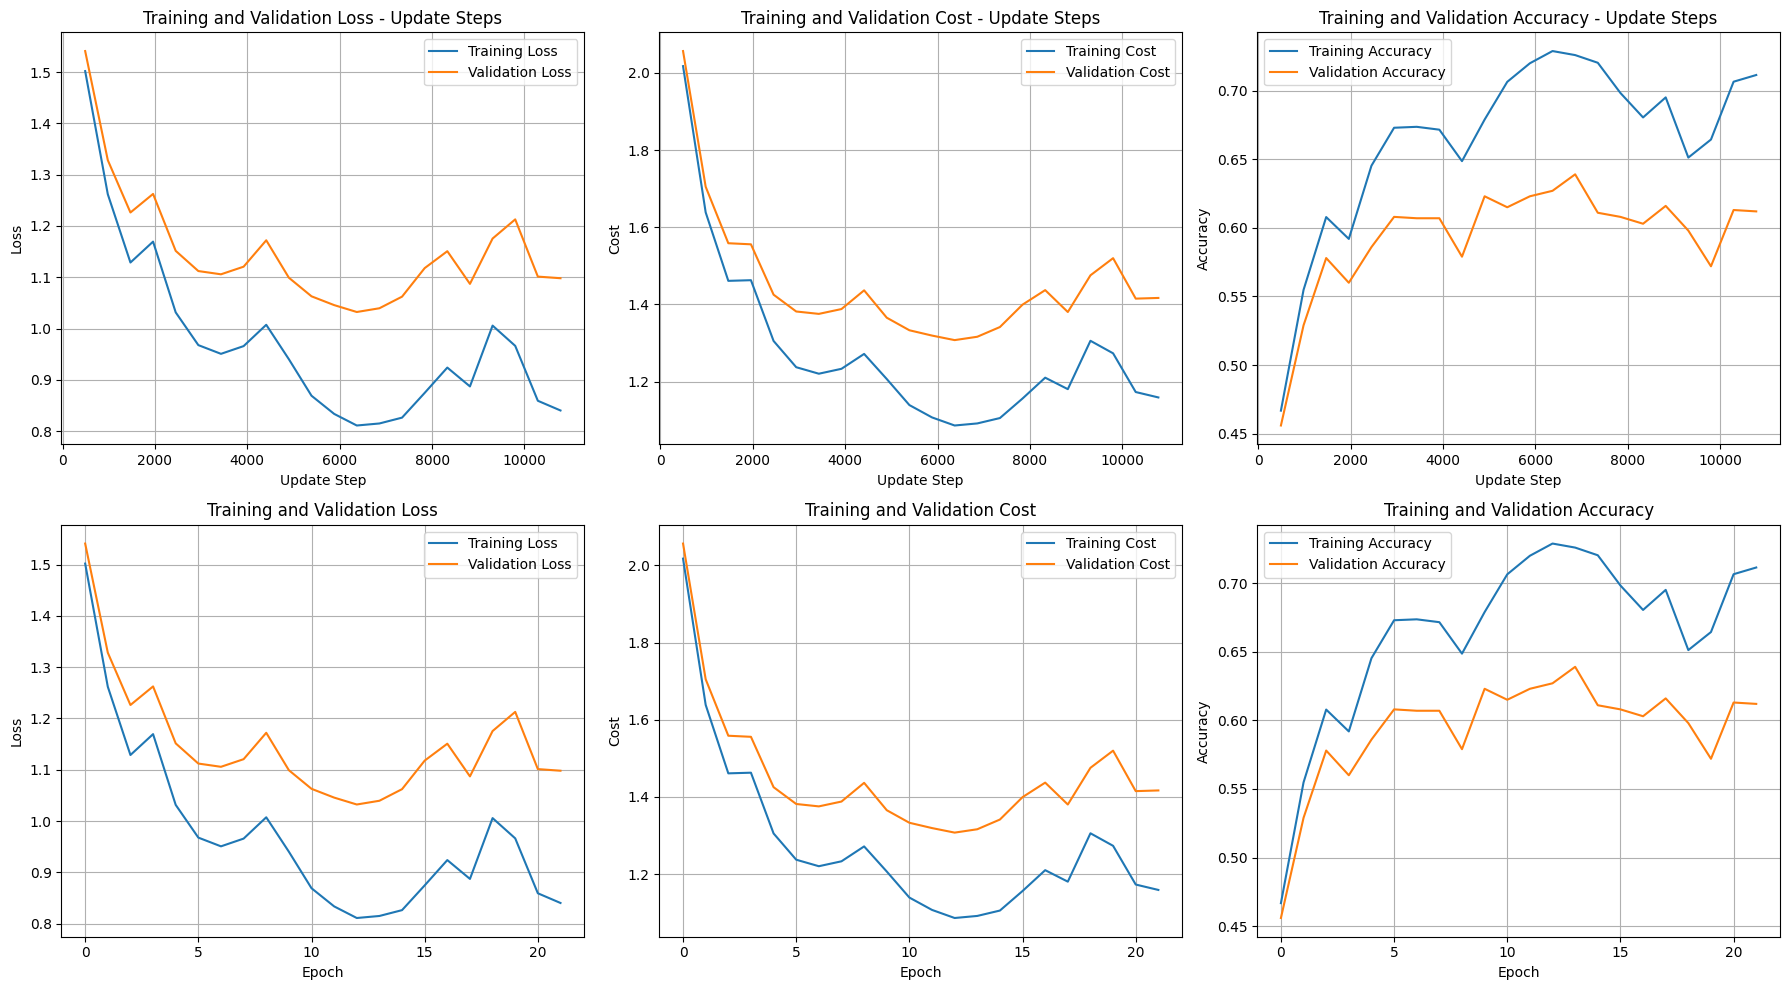

In [62]:
arch2_experiment2()

In [63]:
def experiment5():
    GDparams = {
        "f": 4,
        "nf": 40,
        "nh": 300,
        "n_cycles": 4,
        "step": 800,
        "eta_min": 1e-5,
        "eta_max": 1e-1,
        "n_batch": 100,
        "lam": 0.0025,
    }

    rng = np.random.default_rng(42)
    run_cyclical_experiments_increase_steps(
        "no-label-smoothing-architecture-5", GDparams, rng, False
    )

Run cyclical experiment with increasing steps...
filter size: 4
number of filters: 40
number of neurons in hidden layer: 300
number of cycles: 4
initial_step size: 800
eta_min: 1e-05
eta_max: 0.1
batch size: 100
regularization: 0.0025

transform normalized data for convolution...
finished transforming normalized data for convolution!!

compute matrices for convolution...
finished computing matrices for convolution!!

initialize network...
finished initializing network!!

train the network...
Epoch 1/49 | Training Loss: 1.4711 | Validation Loss: 1.5139 | Training Cost: 2.9928 | Validation Cost: 3.0357 | Training Accuracy: 0.4830 | Validation Accuracy: 0.4600
Epoch 2/49 | Training Loss: 1.2167 | Validation Loss: 1.3117 | Training Cost: 2.2892 | Validation Cost: 2.3842 | Training Accuracy: 0.5762 | Validation Accuracy: 0.5450
Epoch 3/49 | Training Loss: 1.0503 | Validation Loss: 1.1881 | Training Cost: 1.9491 | Validation Cost: 2.0869 | Training Accuracy: 0.6391 | Validation Accuracy: 0.5

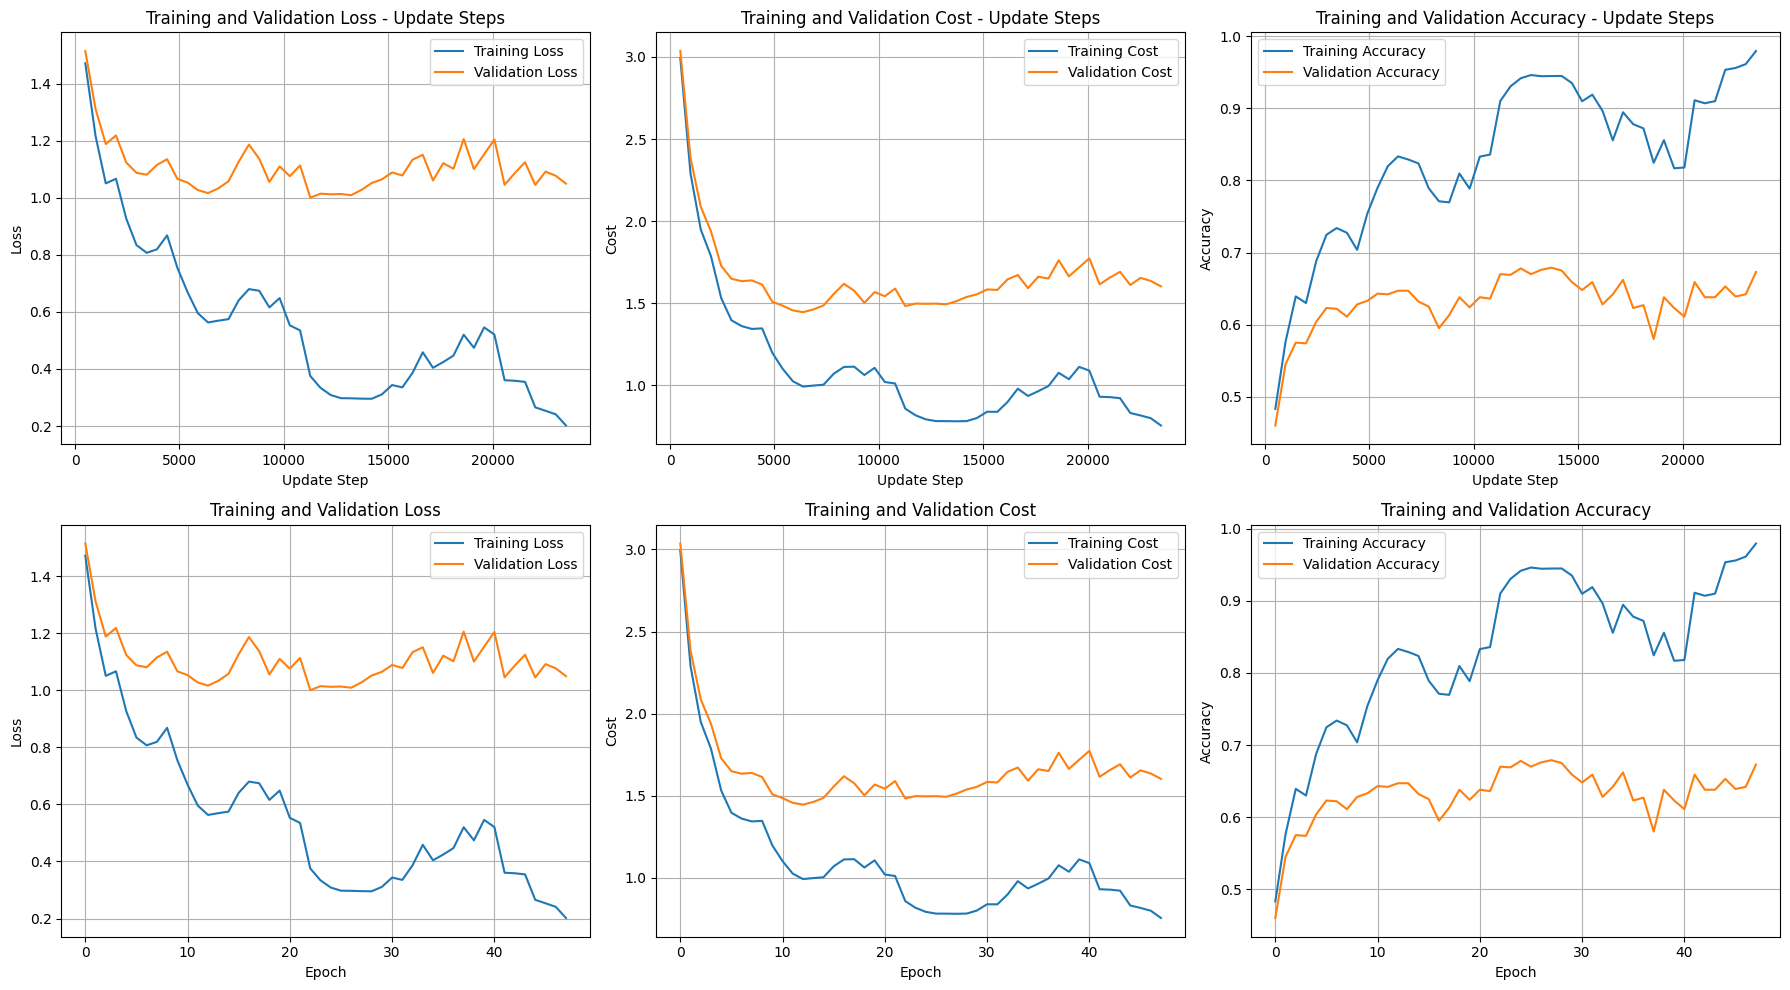

In [64]:
experiment5()

## Exercise 4 - Large Neural Networks with regularization and label smoothing

In [65]:
def experiment6():
    GDparams = {
        "f": 4,
        "nf": 40,
        "nh": 300,
        "n_cycles": 4,
        "step": 800,
        "eta_min": 1e-5,
        "eta_max": 1e-1,
        "n_batch": 100,
        "lam": 0.0025,
    }

    rng = np.random.default_rng(42)
    run_cyclical_experiments_increase_steps(
        "label-smoothing-architecture-5", GDparams, rng, True
    )

Run cyclical experiment with increasing steps...
filter size: 4
number of filters: 40
number of neurons in hidden layer: 300
number of cycles: 4
initial_step size: 800
eta_min: 1e-05
eta_max: 0.1
batch size: 100
regularization: 0.0025

transform normalized data for convolution...
finished transforming normalized data for convolution!!

compute matrices for convolution...
finished computing matrices for convolution!!

initialize network...
finished initializing network!!

train the network...
Epoch 1/49 | Training Loss: 1.5209 | Validation Loss: 1.5592 | Training Cost: 3.0352 | Validation Cost: 3.0735 | Training Accuracy: 0.4813 | Validation Accuracy: 0.4580
Epoch 2/49 | Training Loss: 1.2982 | Validation Loss: 1.3747 | Training Cost: 2.3460 | Validation Cost: 2.4224 | Training Accuracy: 0.5697 | Validation Accuracy: 0.5320
Epoch 3/49 | Training Loss: 1.1566 | Validation Loss: 1.2625 | Training Cost: 2.0219 | Validation Cost: 2.1277 | Training Accuracy: 0.6280 | Validation Accuracy: 0.5

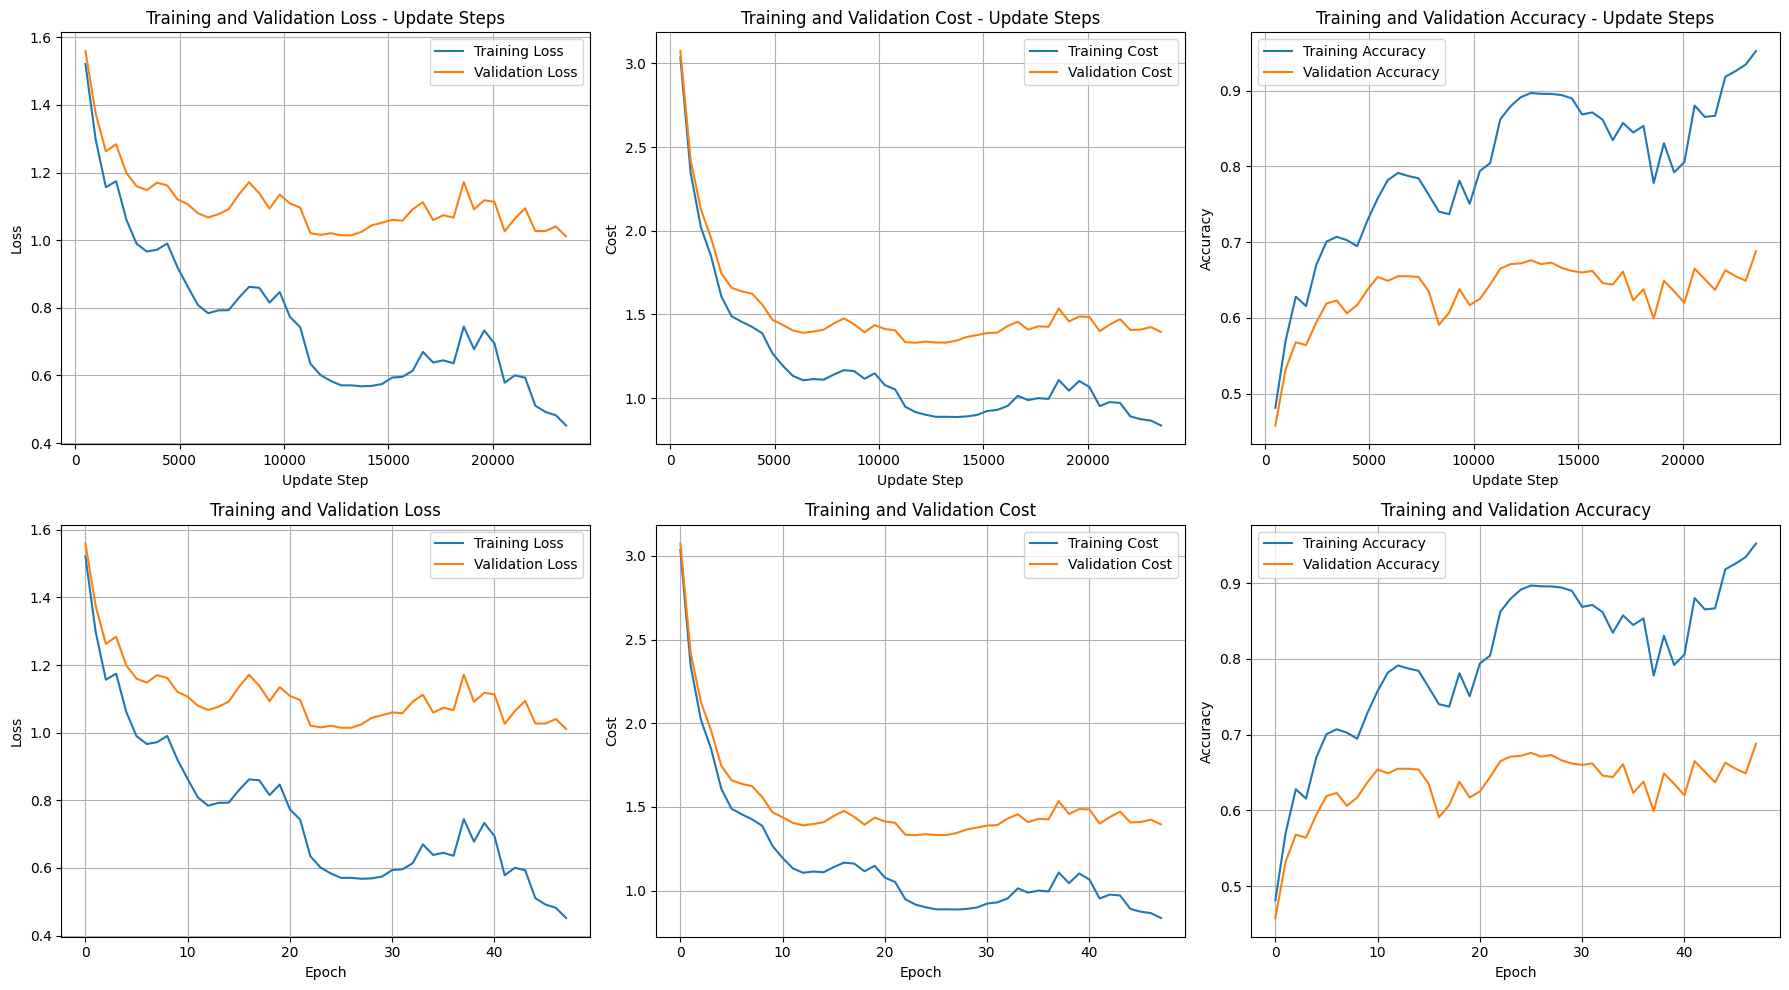

In [66]:
experiment6()

/var/folders/73/y8z3_15n0c3fnwk5fkhj6ql40000gn/T/ipykernel_15242/1542401671.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(architectures, rotation=45, ha="right")
/var/folders/73/y8z3_15n0c3fnwk5fkhj6ql40000gn/T/ipykernel_15242/1542401671.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(architectures, rotation=45, ha="right")


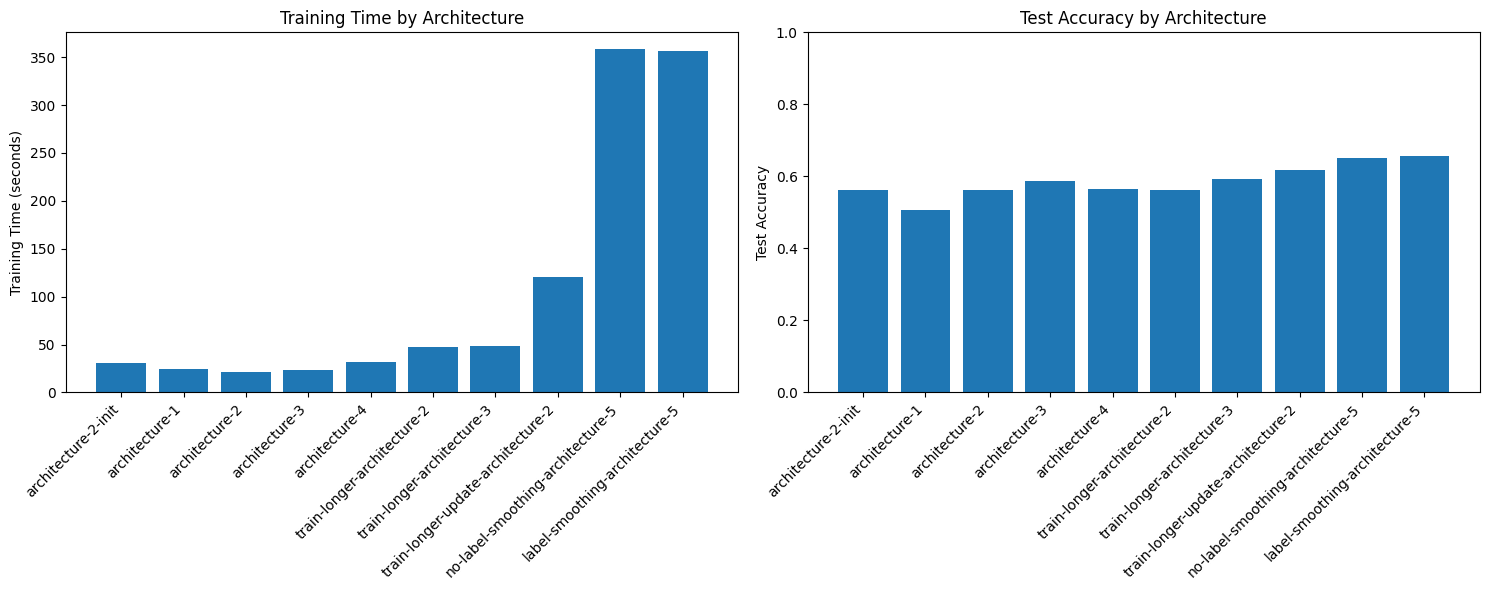

In [67]:
training_results(training_time_result, test_accuracy_result)